In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_color_codes('deep')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition

plt.rcParams['figure.figsize'] = (8, 6)

meanprops = {'marker':'o',
             'markerfacecolor':'white', 
             'markeredgecolor':'black',
             'markeredgewidth': 1.5,
             'markersize':'10'}

# Functions

In [2]:
# Scree plot
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xticks(np.arange(0, pca.n_components_)+1)
    plt.xlabel("rank of the inertia axis")
    plt.ylabel("percentage of inertia")
    plt.title("Scree plot")
    
# Correlation circles
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # Display factorial planes in axis_ranks
        if d2 < n_comp:
            # Initialize the figure
            fig, ax = plt.subplots(figsize=(7,6))

            # Determine graph limits
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Display arrows
            # If there are more than 30 arrows, do not display the triangle at their end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see doc: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', 
                                 rotation=label_rotation, color="blue", alpha=0.5)

            # Display the circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define graph limits
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # Display horizontal and vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Axis names with explained inertia percentage
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation circle (F{} and F{})".format(d1+1, d2+1))


# Projection on the principal components
def display_pca(X, pcs, axis_ranks, clusters=None, labels=None, show_features=True, xmin=None, xmax=None, ymin=None, ymax=None):
    for d1, d2 in axis_ranks:
        fig, ax = plt.subplots()
        for cluster in np.unique(clusters):
            mask = clusters == cluster
            ax.scatter(X[mask, d1], X[mask, d2], label='Cluster {}'.format(cluster))
        
        xmin = ax.get_xlim()[0] if xmin is None else xmin
        xmax = ax.get_xlim()[1] if xmax is None else xmax
        ymin = ax.get_ylim()[0] if ymin is None else ymin
        ymax = ax.get_ylim()[1] if ymax is None else ymax
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        if show_features:
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
            pcs[d1,:]*xmax, pcs[d2,:]*ymax, 
            angles='xy', scale_units='xy', scale=1, color="grey")
            # Display feature names  
            if labels is not None:  
                for l,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x*xmax, y*ymax, labels[l], fontsize='14', ha='left', va='center', 
                                color="blue", alpha=0.5)
        
        plt.title('Projection of {} individuals'.format(X.shape[0]))
        plt.xlabel('F{}'.format(d1+1))
        plt.ylabel('F{}'.format(d2+1))
        plt.legend();

# RFM Segmentation

In [3]:
df_rfm = pd.read_csv('./data/df_rfm.csv', index_col=0)
df_rfm.head()

,recency,frequency,mean_spending
customer_unique_id,,,
4b3207464f5f7a48a7f63fa0b1251d86,601,1,9.9
527cd2850ef91088969ffbef0103dec3,601,1,11.9
29a63a400c3ca9982907ce8de1f19527,601,1,10.9
b6b2c3c8fd76769b478618a3c2505009,601,1,10.9
f7be9bec658c62ab6240b44cd26c0b84,601,2,10.4


In [4]:
df_rfm.dtypes

recency            int64
frequency          int64
mean_spending    float64
dtype: object

## KMeans

In [5]:
from sklearn.cluster import KMeans

In [6]:
# Prepare data for clustering
X_rfm = df_rfm.copy()

# Centering and scaling
scaler = StandardScaler()
X_rfm_scaled = scaler.fit_transform(X_rfm)
# Convert back to DataFrame
X_rfm_scaled = pd.DataFrame(X_rfm_scaled, columns=X_rfm.columns, index=X_rfm.index)

### Analysis with Yellowbrick

In [7]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 6)

We will use the `KElbowVisualizer` function from the `yellowbrick` package to apply the elbow method to our data and determine the optimal number of clusters.

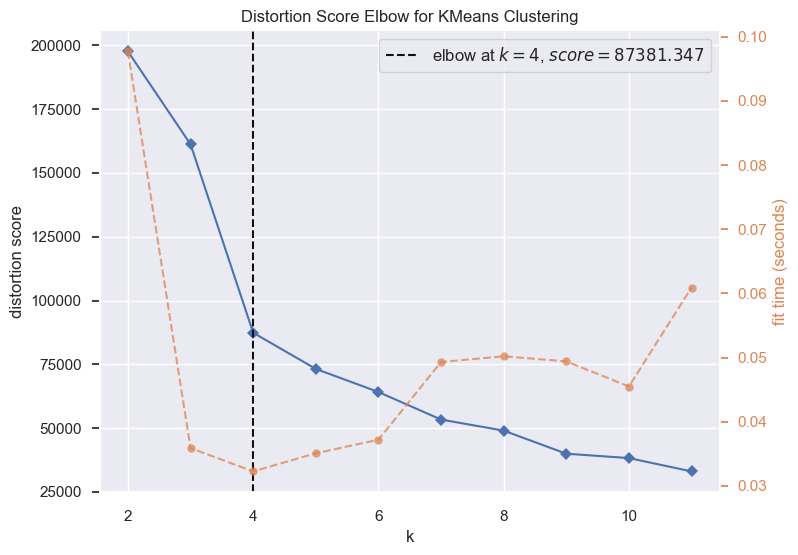

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

In [9]:
plt.rcParams['figure.figsize'] = (8, 6)

By default, the metric used is `distortion`, which calculates the sum of squared distances between each point and its cluster. Other metrics, such as `calinski_harabasz`, can also be used.

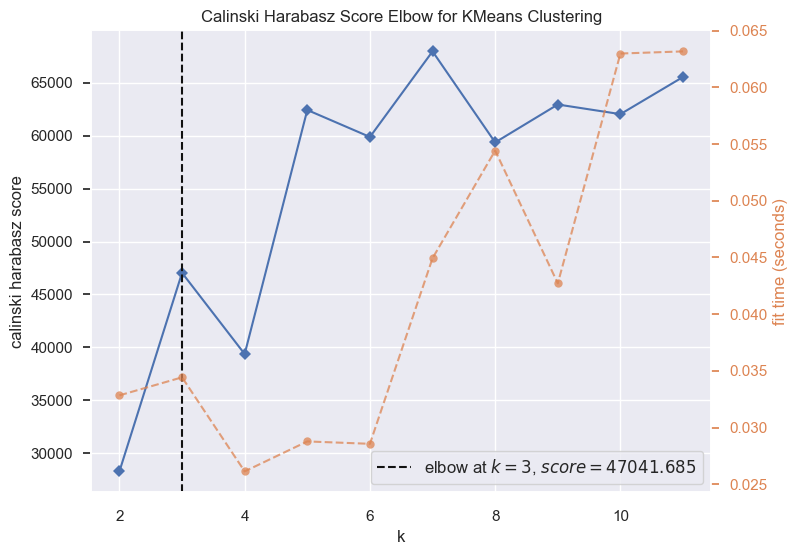

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [10]:
# Instantiate the clustering model and visualizer 
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz')

visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

To determine if a point x belongs to the correct cluster, we can measure its silhouette coefficient. It ranges from -1 to 1, and the closer it is to 1, the better the assignment of x to its cluster. To evaluate clustering, we can calculate its average silhouette coefficient.

In [11]:
# Take a sample of the data for faster computation
X_rfm_sample = X_rfm.sample(10000, random_state=1)
X_rfm_scaled_sample = scaler.transform(X_rfm_sample)
# Convert back to DataFrame
X_rfm_scaled_sample = pd.DataFrame(X_rfm_scaled_sample, index=X_rfm_sample.index, 
                                   columns=X_rfm_sample.columns)

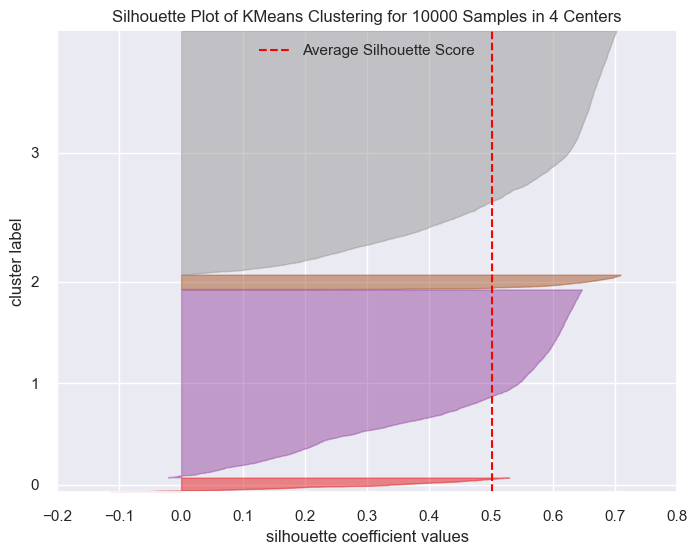

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [12]:
n_clust = 4
# Instantiate the clustering model and visualizer
kmeans = KMeans(n_clust, random_state=5)
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_rfm_scaled_sample)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

Clusters 0 and 1 are much larger than the others, meaning they contain more points. We can also see that the silhouette coefficient is negative for some points, indicating they were assigned to the wrong cluster. The dashed line indicates the average silhouette coefficient.

We can directly calculate the average silhouette coefficient using `sklearn.metrics.silhouette_score`.

In [13]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
silhouette_score(X_rfm_scaled_sample, labels, metric='euclidean')

np.float64(0.5010023255571486)

### Clustering

In [14]:
# Clustering with K-means
kmeans = KMeans(n_clusters=n_clust, random_state=5)
kmeans.fit(X_rfm_scaled)

# Retrieve clusters assigned to each individual
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3], dtype=int32)

In [15]:
# Number of clients per cluster
pd.Series(clusters).value_counts()

1    50719
0    37808
3     2479
2      214
Name: count, dtype: int64

### Visualization

#### Visualization on the factorial planes

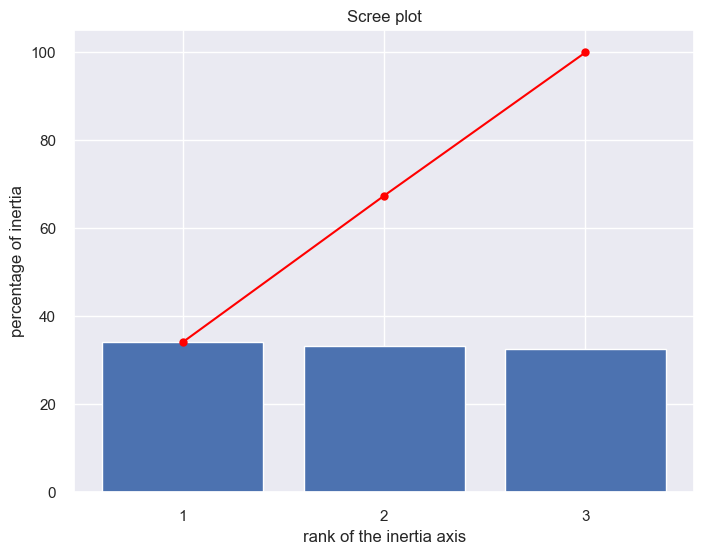

In [16]:
# PCA
n_comp = 3 # number of components
pca = decomposition.PCA(n_components=n_comp).fit(X_rfm_scaled)
X_rfm_projected = pca.transform(X_rfm_scaled)

# Scree plot
display_scree_plot(pca)

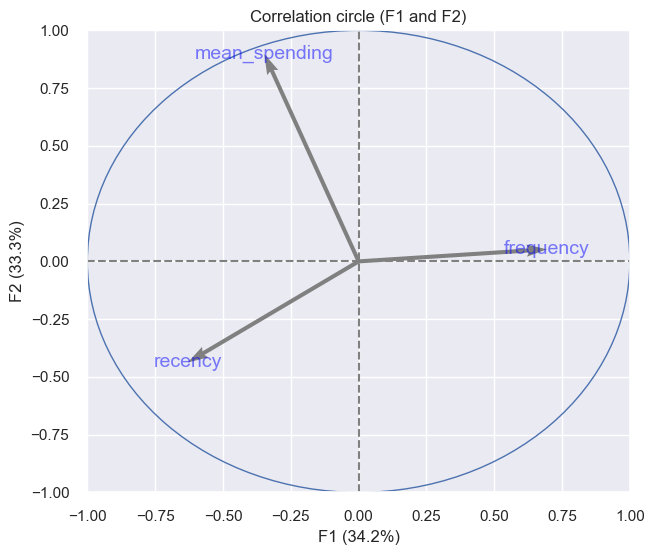

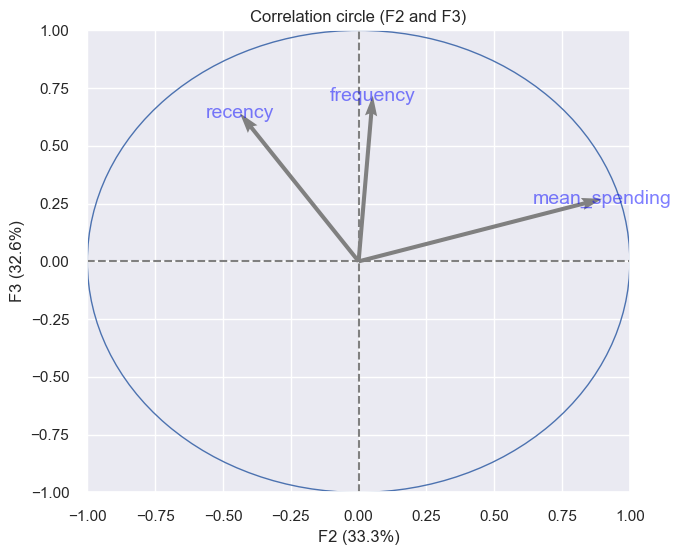

In [17]:
# Correlation circle
pcs = pca.components_
axis_ranks = [(0,1), (1,2)]
labels = X_rfm.columns
display_circles(pcs, n_comp, pca, axis_ranks, labels=labels)

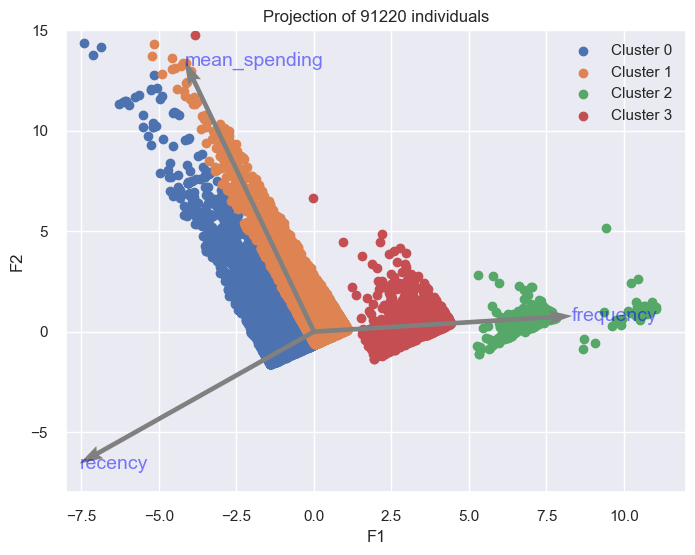

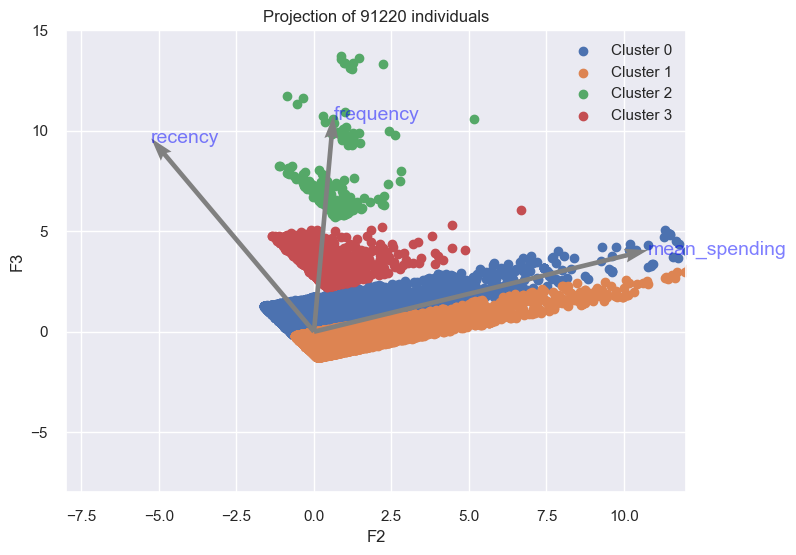

In [18]:
display_pca(X_rfm_projected, pcs, axis_ranks, clusters, labels, show_features=True, xmin=-8, xmax=12, ymin=-8, ymax=15)

3D visualization

In [19]:
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(projection='3d')
# x = X_rfm_projected[:, 0]
# y = X_rfm_projected[:, 1]
# z = X_rfm_projected[:, 2]
# ax.scatter(x, y, z, c=clusters, cmap='viridis')
# ax.set_xlabel('F1')
# ax.set_ylabel('F2')
# ax.set_zlabel('F3');

#### Visualization in features space

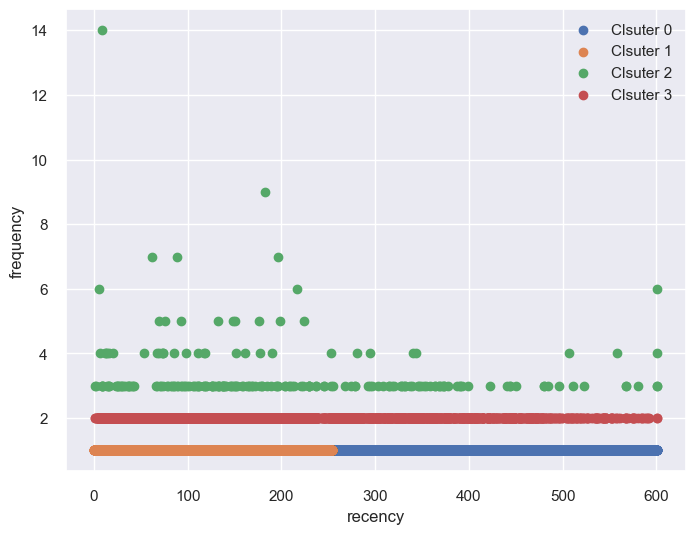

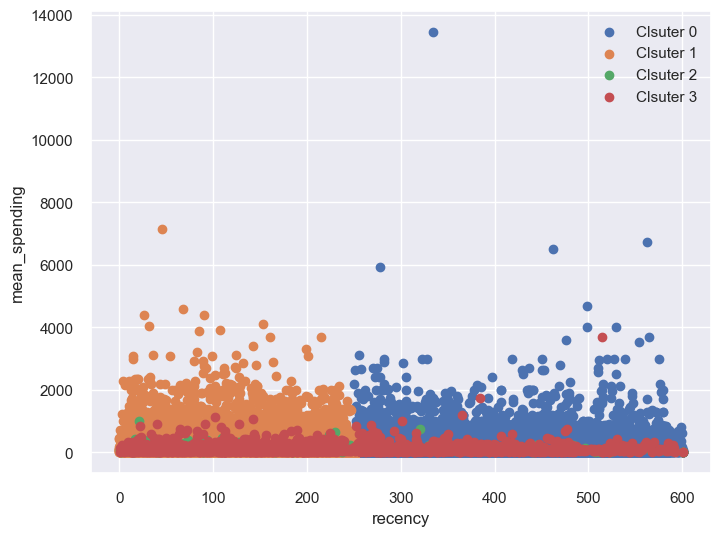

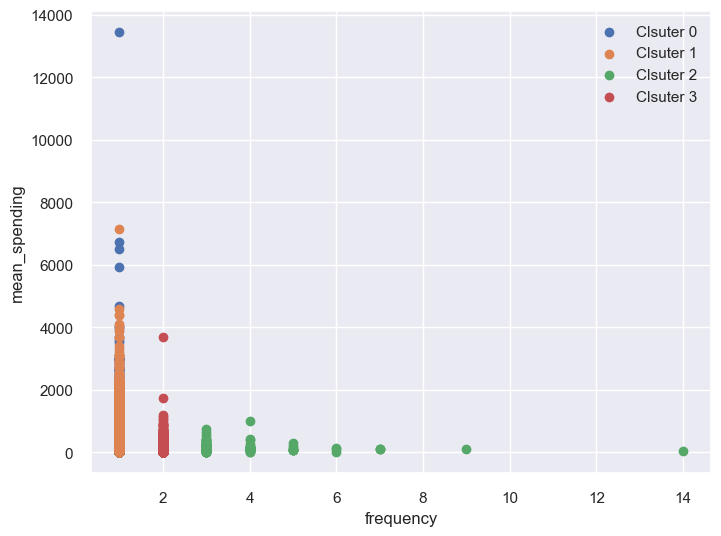

In [20]:
for (i, j) in ((0,1), (0,2), (1,2)):
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfm.iloc[mask, i], X_rfm.iloc[mask, j], label='Clsuter {}'.format(cluster))
    plt.xlabel(X_rfm.columns[i])
    plt.ylabel(X_rfm.columns[j])
    plt.legend();

#### Box plots

In [21]:
df_rfm['cluster'] = clusters

Let's draw the boxplots referenced by features and grouped by clusters

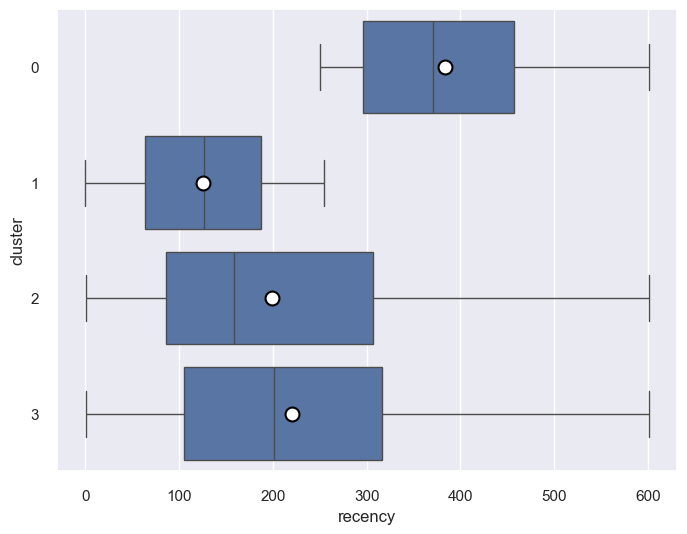

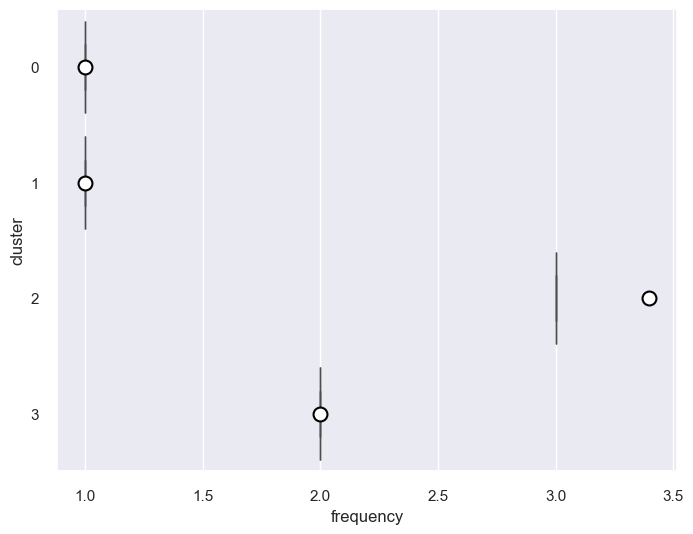

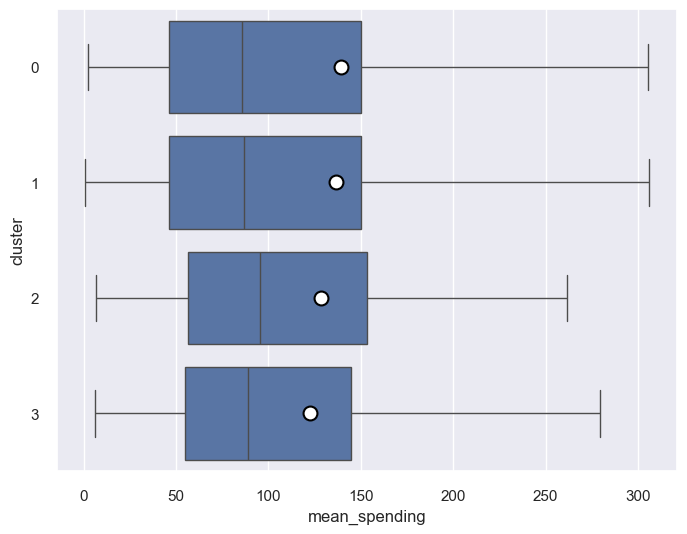

In [22]:
for col in df_rfm.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=df_rfm, orient='h', showfliers=False, showmeans=True,
               meanprops=meanprops)

#### Distribution plots

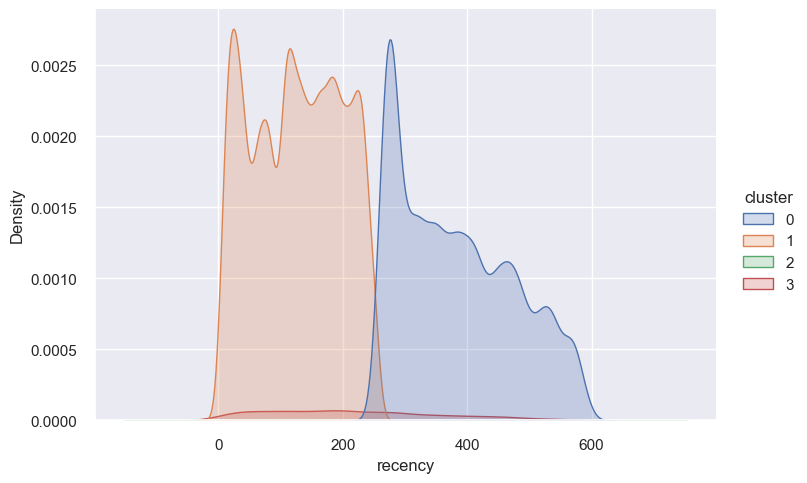

In [23]:
sns.displot(x='recency', data=df_rfm, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5);

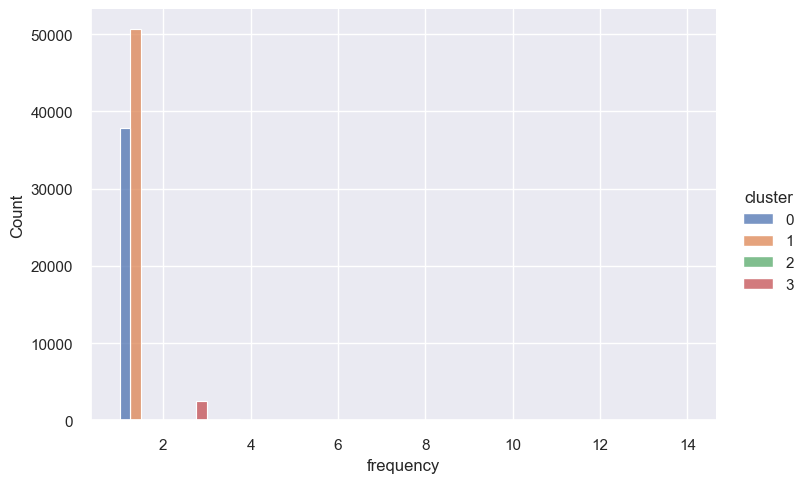

In [24]:
sns.displot(x='frequency', data=df_rfm, hue='cluster', kind='hist', palette='deep', aspect=1.5, 
            binwidth=1, multiple='dodge');

In [25]:
pd.crosstab(df_rfm['frequency'], df_rfm['cluster'])

cluster,0,1,2,3
frequency,,,,
1,37808,50719,0,0
2,0,0,0,2479
3,0,0,168,0
4,0,0,29,0
5,0,0,9,0
6,0,0,3,0
7,0,0,3,0
9,0,0,1,0
14,0,0,1,0


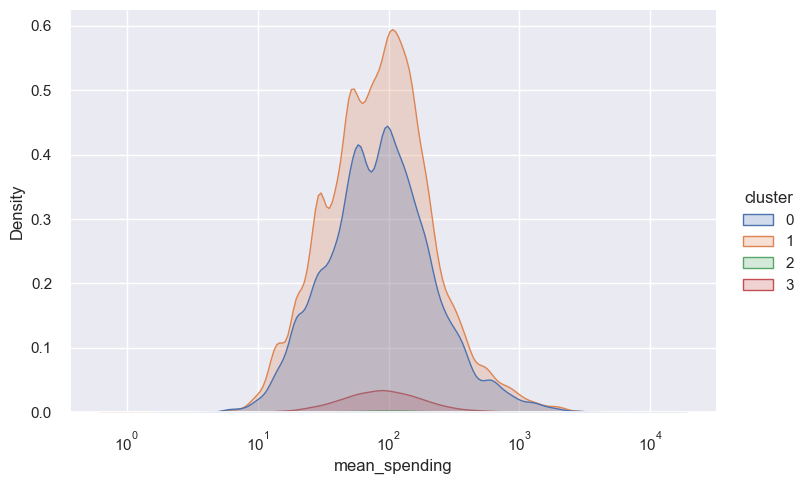

In [26]:
sns.displot(x='mean_spending', data=df_rfm, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5,
           log_scale=True);

We can conclude that:
- Cluster 0 represents recent customers (< 250 days)
- Cluster 1 represents long-standing customers (> 250 days)
- Cluster 2 represents customers who have placed multiple orders
- Cluster 3 represents customers who spend a lot (around 1,000 on average)

# RFMS Segmentation

Here we add the review **s**core feature.

In [62]:
df_rfms = pd.read_csv('./data/df_rfms.csv', index_col=0)
df_rfms.head()

,recency,frequency,mean_spending,review_score
customer_unique_id,,,,
4b3207464f5f7a48a7f63fa0b1251d86,601,1,9.9,5.0
527cd2850ef91088969ffbef0103dec3,601,1,11.9,5.0
29a63a400c3ca9982907ce8de1f19527,601,1,10.9,5.0
b6b2c3c8fd76769b478618a3c2505009,601,1,10.9,5.0
f7be9bec658c62ab6240b44cd26c0b84,601,2,10.4,5.0


## KMeans

In [63]:
from sklearn.cluster import KMeans

In [64]:
X_rfms = df_rfms.copy()

scaler = StandardScaler()
X_rfms_scaled = scaler.fit_transform(X_rfms)
X_rfms_scaled = pd.DataFrame(X_rfms_scaled, columns=X_rfms.columns, index=X_rfms.index)

### Analysis with Yellowbrick

In [65]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 6)

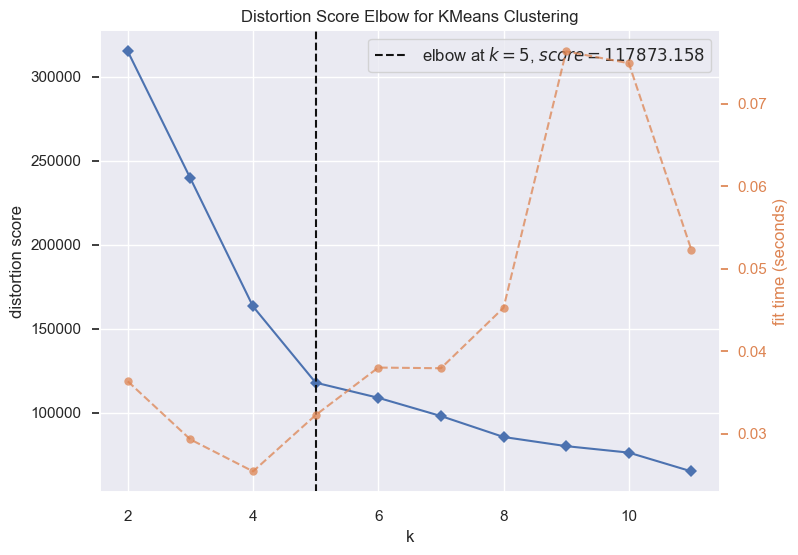

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
plt.rcParams['figure.figsize'] = (8,6)
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(X_rfms_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

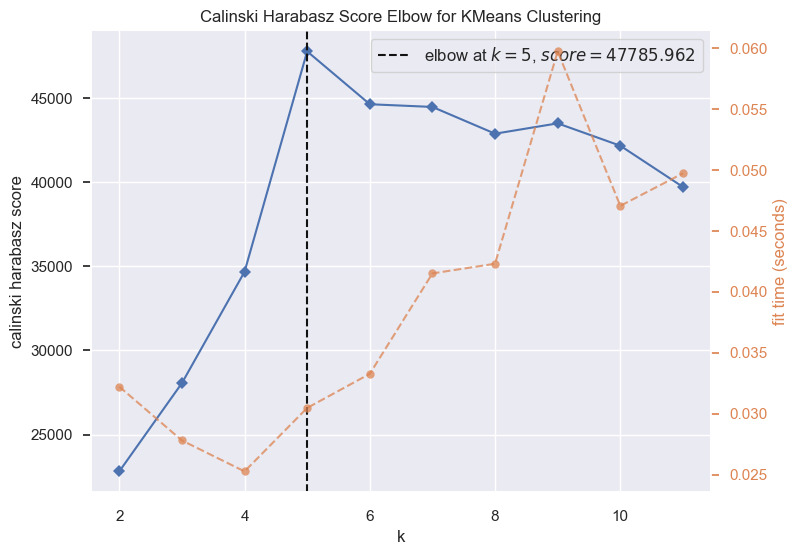

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [67]:
# Instantiate the clustering model and visualizer 
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz')

visualizer.fit(X_rfms_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

In [68]:
X_rfms_sample = X_rfms.sample(10000, random_state=1)
X_rfms_scaled_sample = scaler.transform(X_rfms_sample)
X_rfms_scaled_sample = pd.DataFrame(X_rfms_scaled_sample, 
                                    index=X_rfms_sample.index, columns=X_rfms_sample.columns)

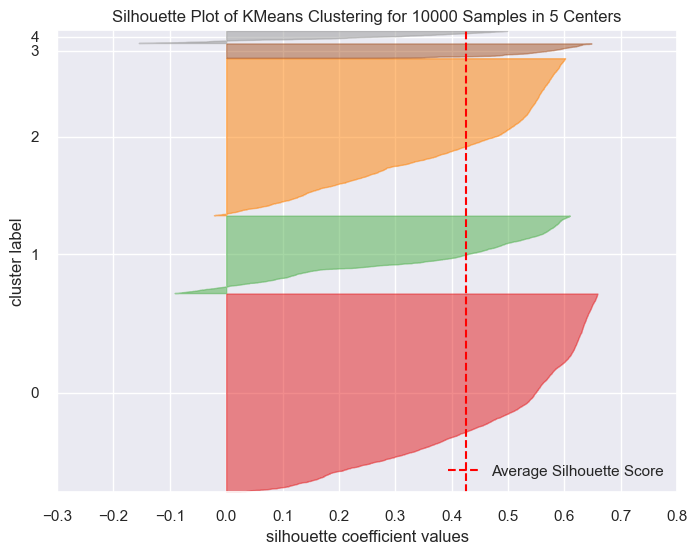

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [69]:
n_clust = 5
# Instantiate the clustering model and visualizer
kmeans = KMeans(n_clust, random_state=12)
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_rfms_scaled_sample)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

In [70]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
silhouette_score(X_rfms_scaled_sample, labels, metric='euclidean')

np.float64(0.4263084905018286)

### Clustering

In [71]:
n_clust = 5
kmeans = KMeans(n_clusters=n_clust, random_state=12)
kmeans.fit(X_rfms_scaled)

clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3, 4], dtype=int32)

In [72]:
# Number of customers per cluster
pd.Series(clusters).value_counts()

2    29543
1    27863
0    19475
4    11646
3     2693
Name: count, dtype: int64

### Visualization

#### Visualization on the factorial planes

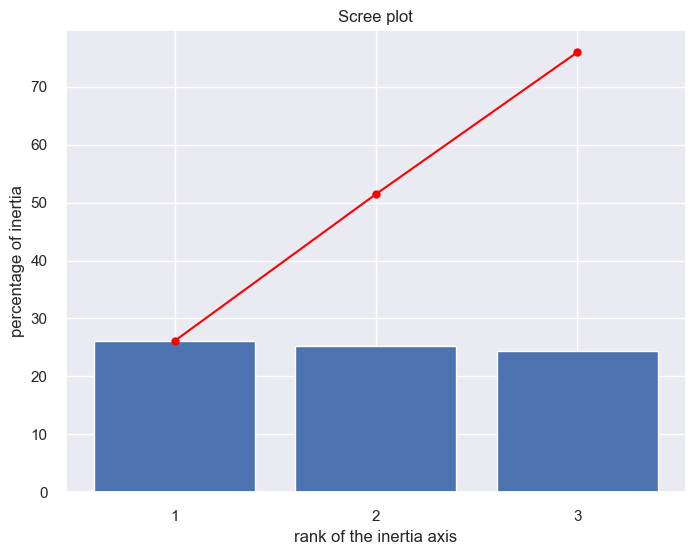

In [73]:
# PCA
n_comp = 3
pca = decomposition.PCA(n_components=n_comp).fit(X_rfms_scaled)
X_rfms_projected = pca.transform(X_rfms_scaled)

# Scree plot
display_scree_plot(pca)

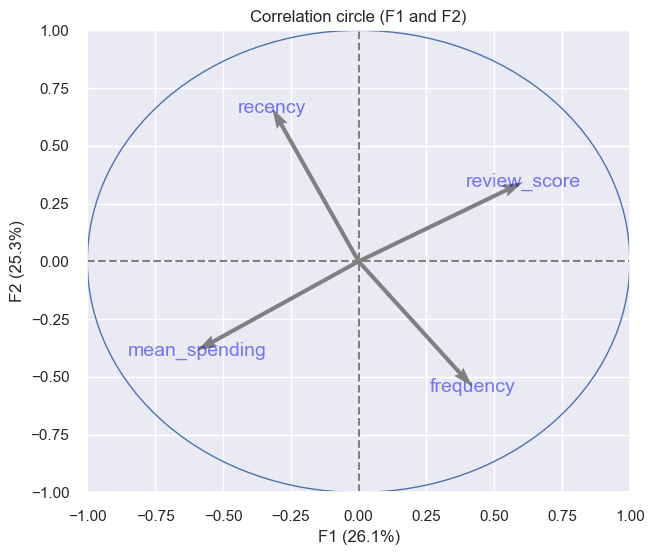

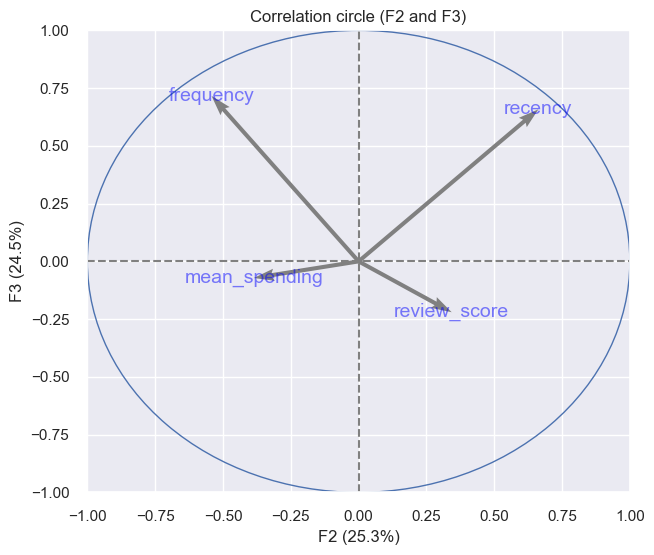

In [74]:
pcs = pca.components_
axis_ranks = [(0,1), (1,2)]
labels = X_rfms.columns
display_circles(pcs, n_comp, pca, axis_ranks, labels=labels)

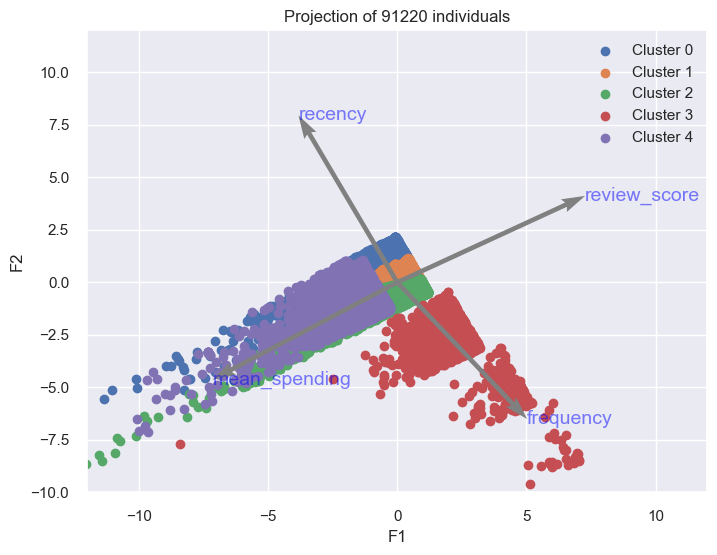

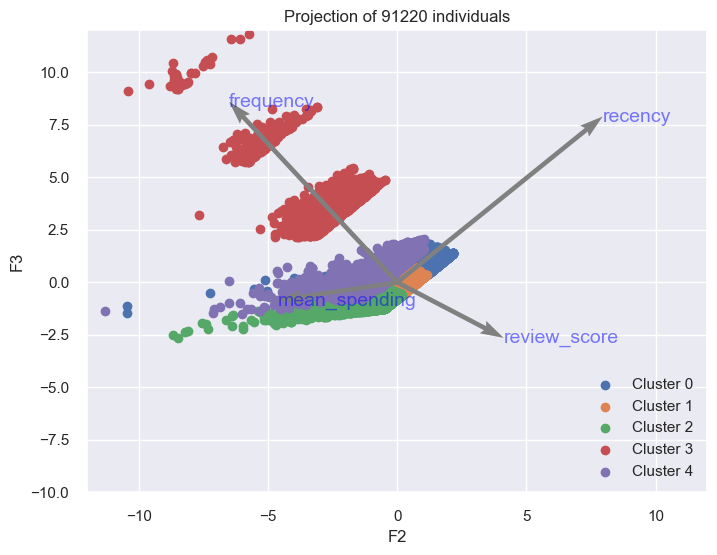

In [75]:
display_pca(X_rfms_projected, pcs, axis_ranks, clusters, labels, show_features=True, xmin=-12, xmax=12, ymin=-10, ymax=12)

3D visualization

In [76]:
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(projection='3d')
# x = X_rfms_projected[:, 0]
# y = X_rfms_projected[:, 1]
# z = X_rfms_projected[:, 2]
# ax.scatter(x, y, z, c=clusters, cmap='viridis')
# ax.set_xlabel('F1')
# ax.set_ylabel('F2')
# ax.set_zlabel('F3');

#### Visualization in features space

In [77]:
import itertools

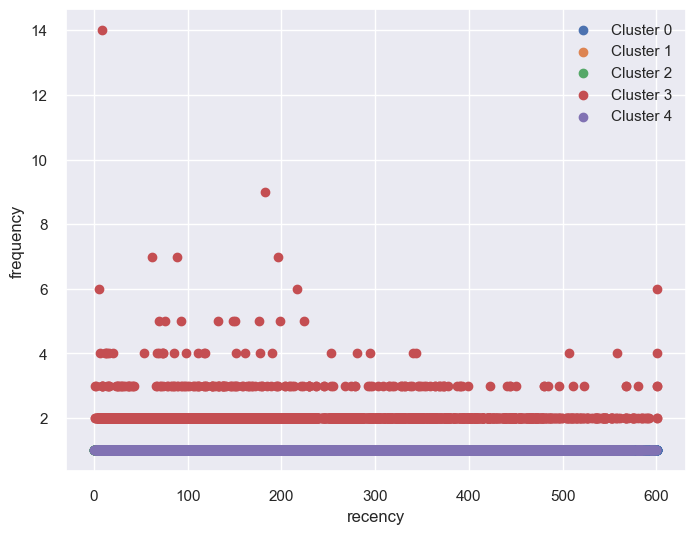

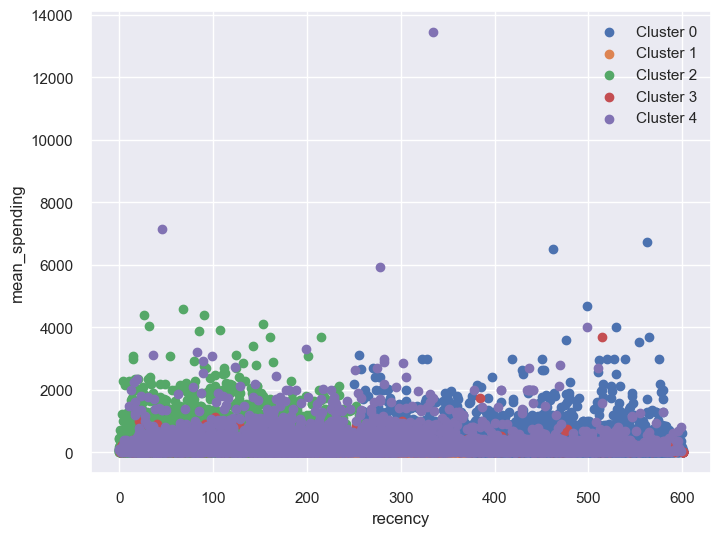

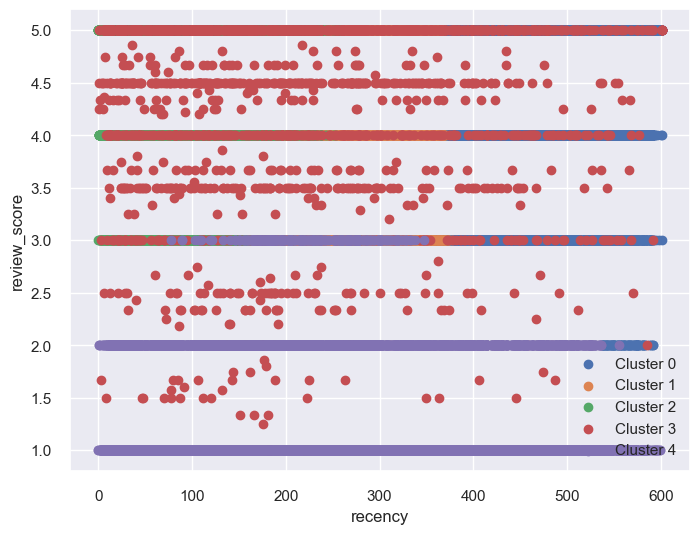

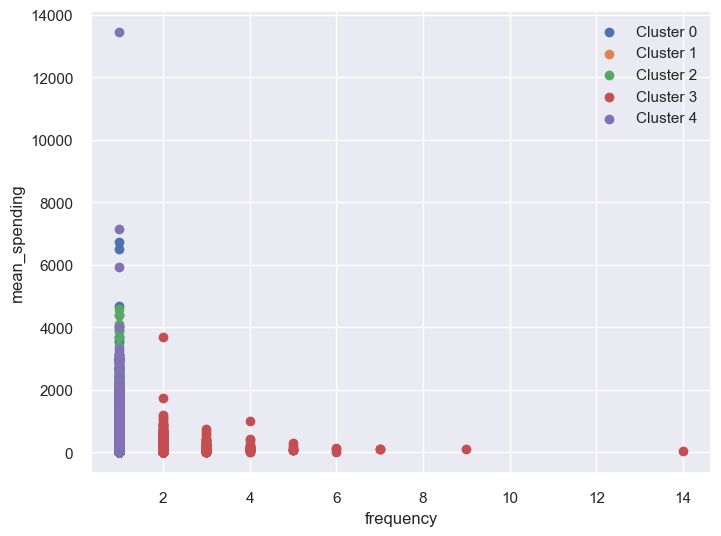

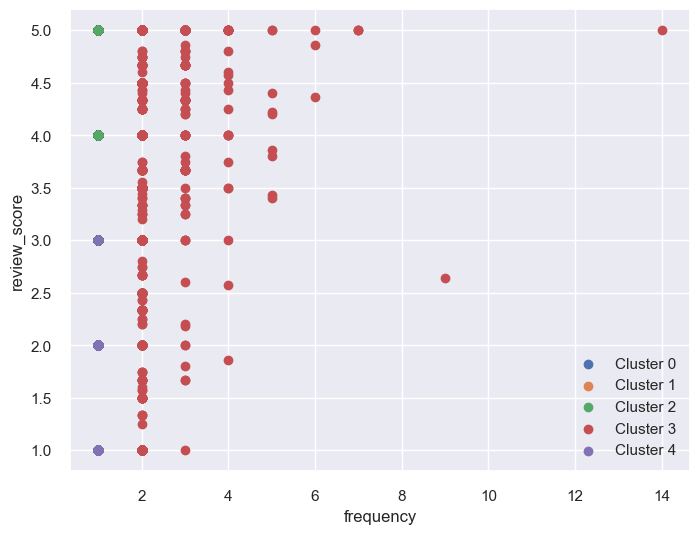

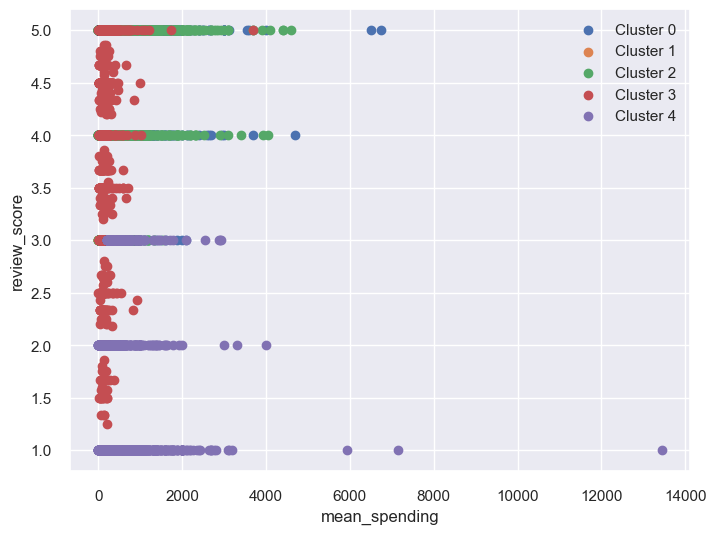

In [78]:
for (i, j) in itertools.combinations(range(X_rfms.shape[1]), 2):
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfms.iloc[mask, i], X_rfms.iloc[mask, j], label='Cluster {}'.format(cluster))
    #plt.xticks(rotation=30)
    plt.xlabel(X_rfms.columns[i])
    plt.ylabel(X_rfms.columns[j])
    plt.legend();

#### Box plots

In [79]:
df_rfms['cluster'] = clusters

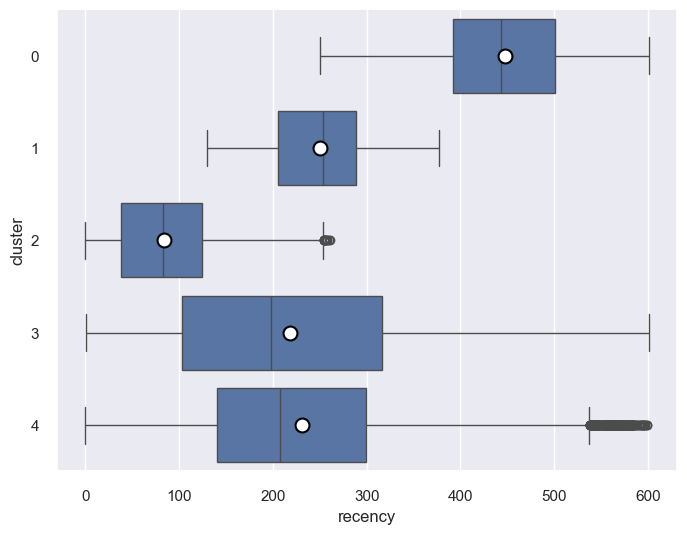

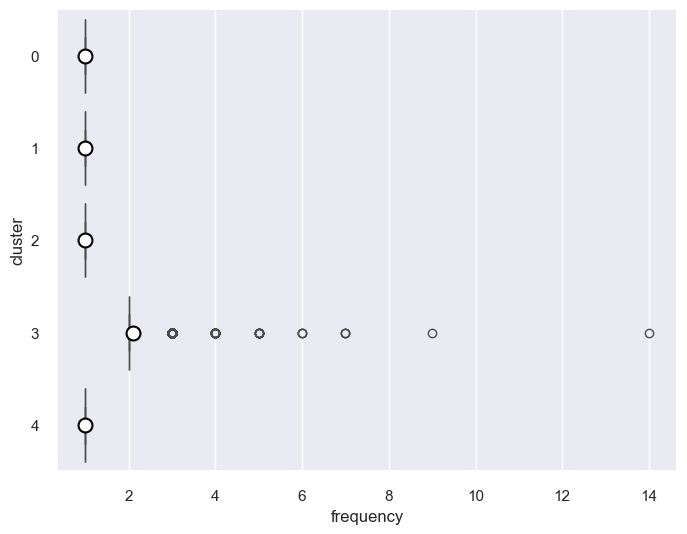

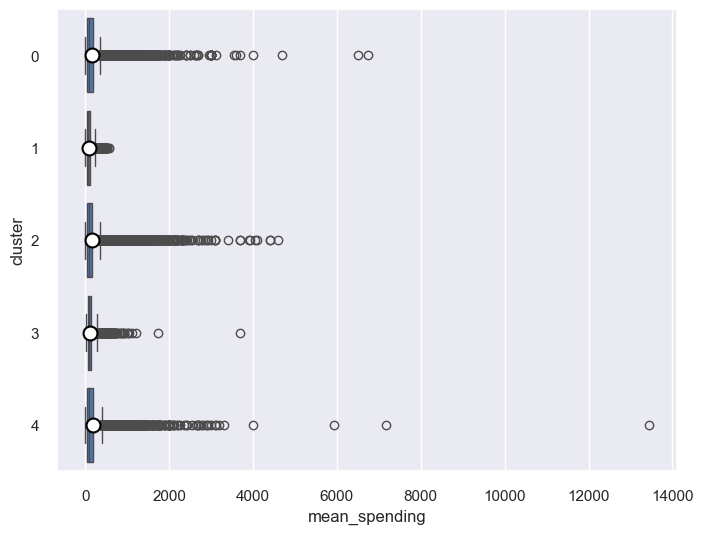

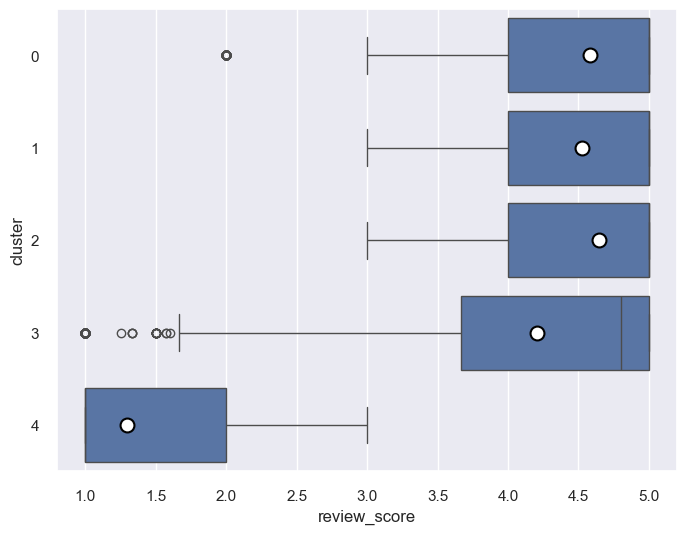

In [80]:
for col in df_rfms.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=df_rfms, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

#### Distribution plots

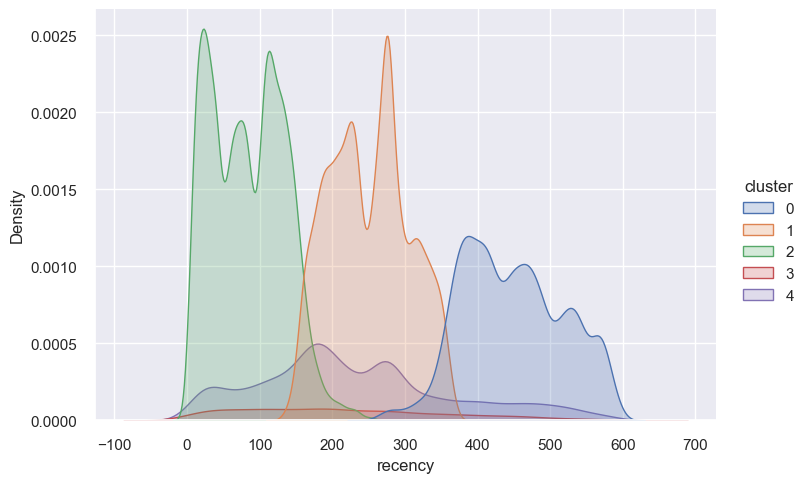

In [81]:
sns.displot(x='recency', data=df_rfms, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5);

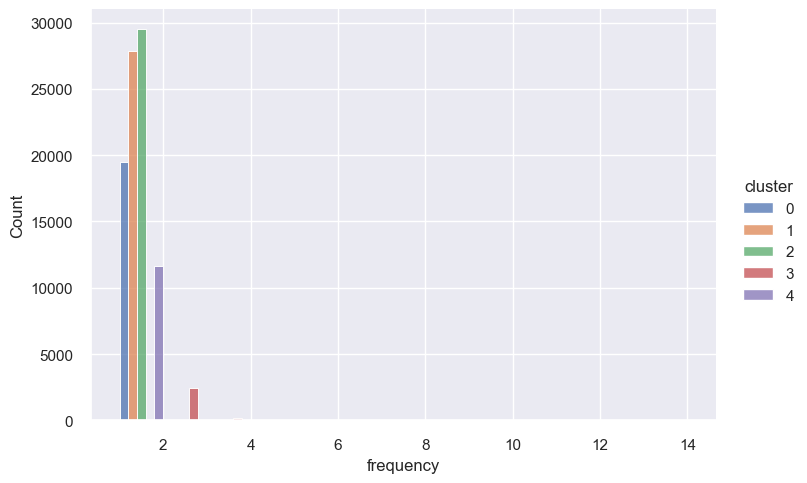

In [82]:
sns.displot(x='frequency', data=df_rfms, hue='cluster', kind='hist', palette='deep', aspect=1.5, 
            binwidth=1, multiple='dodge');

In [83]:
pd.crosstab(df_rfms['frequency'], df_rfms['cluster'])

cluster,0,1,2,3,4
frequency,,,,,
1,19475,27863,29543,0,11646
2,0,0,0,2479,0
3,0,0,0,168,0
4,0,0,0,29,0
5,0,0,0,9,0
6,0,0,0,3,0
7,0,0,0,3,0
9,0,0,0,1,0
14,0,0,0,1,0


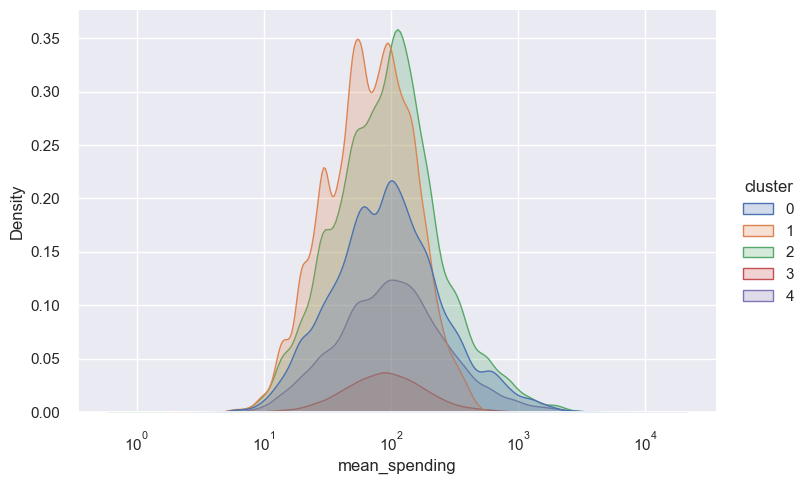

In [84]:
sns.displot(x='mean_spending', data=df_rfms, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5,
           log_scale=True);

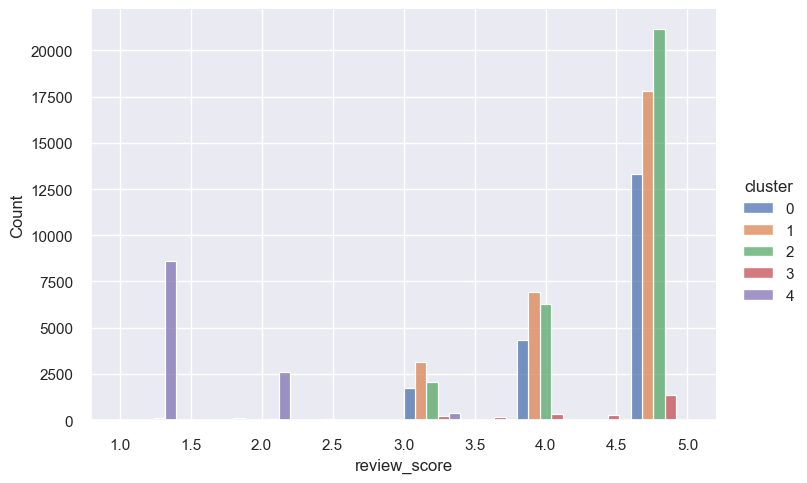

In [85]:
sns.displot(x='review_score', data=df_rfms, hue='cluster', aspect=1.5, palette='deep', multiple='dodge',
           bins=10);

We can conclude that:
- Cluster 0 represents long-standing and satisfied customers,
- Cluster 1 represents recent and satisfied customers
- Cluster 2 represents frequent customers, whether satisfied or not
- Cluster 3 represents high-spending customers,
- Cluster 4 represents unsatisfied or moderately satisfied customers

High-spending customers (cluster 3) are also mostly satisfied (majority of review_scores > 4), and are therefore the most valuable customers.

# RFMST Segmentation

In [86]:
df_rfmst = pd.read_csv('./data/df_rfmst.csv', index_col=0)
df_rfmst.head()

,recency,frequency,mean_spending,review_score,total_items
customer_unique_id,,,,,
4b3207464f5f7a48a7f63fa0b1251d86,601,1,9.9,5.0,1
527cd2850ef91088969ffbef0103dec3,601,1,11.9,5.0,1
29a63a400c3ca9982907ce8de1f19527,601,1,10.9,5.0,1
b6b2c3c8fd76769b478618a3c2505009,601,1,10.9,5.0,1
f7be9bec658c62ab6240b44cd26c0b84,601,2,10.4,5.0,2


## KMeans

In [87]:
from sklearn.cluster import KMeans

In [88]:
X_rfmst = df_rfmst.copy()

scaler = StandardScaler()
X_rfmst_scaled = scaler.fit_transform(X_rfmst)
X_rfmst_scaled = pd.DataFrame(X_rfmst_scaled, columns=X_rfmst.columns, index=X_rfmst.index)

### Analysis with Yellowbrick

In [89]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 6)

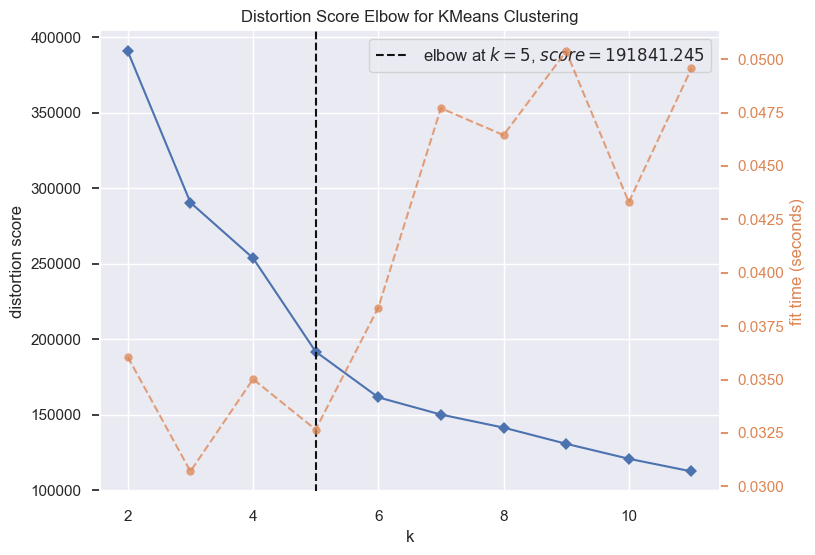

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [90]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
plt.rcParams['figure.figsize'] = (8,6)
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(X_rfmst_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

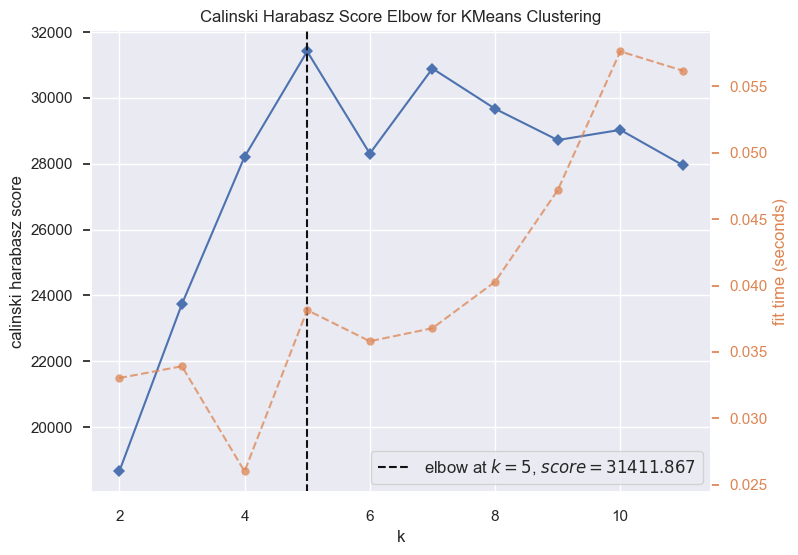

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [91]:
# Instantiate the clustering model and visualizer 
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz')

visualizer.fit(X_rfmst_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

In [92]:
X_rfmst_sample = X_rfmst.sample(10000, random_state=1)
X_rfmst_scaled_sample = scaler.transform(X_rfmst_sample)
X_rfmst_scaled_sample = pd.DataFrame(X_rfmst_scaled_sample, 
                                    index=X_rfmst_sample.index, columns=X_rfmst_sample.columns)

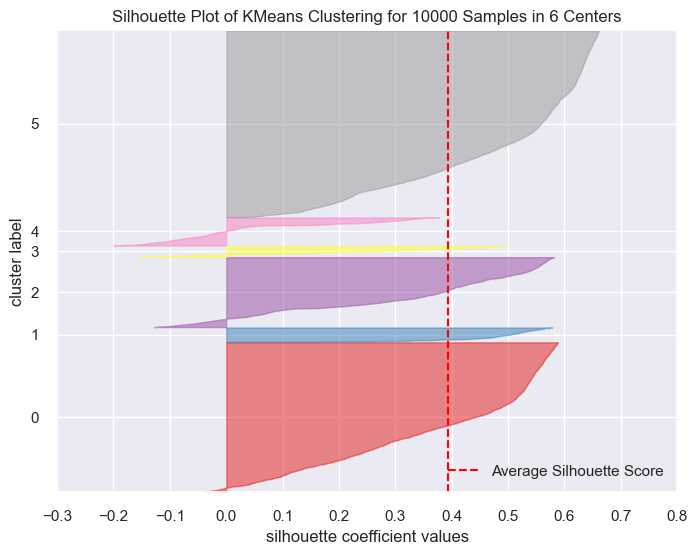

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [93]:
n_clust = 6
# Instantiate the clustering model and visualizer
kmeans = KMeans(n_clust, random_state=0)
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_rfmst_scaled_sample)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

In [94]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
silhouette_score(X_rfmst_scaled_sample, labels, metric='euclidean')

np.float64(0.39269842743598987)

### Clustering

In [95]:
n_clust = 6
kmeans = KMeans(n_clusters=n_clust, random_state=12)
kmeans.fit(X_rfmst_scaled)
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [96]:
# Number of customers per cluster
pd.Series(clusters).value_counts()

1    40361
0    30886
5    15007
4     2706
2     1977
3      283
Name: count, dtype: int64

### Visualization

#### Visualization in features space

In [97]:
import itertools

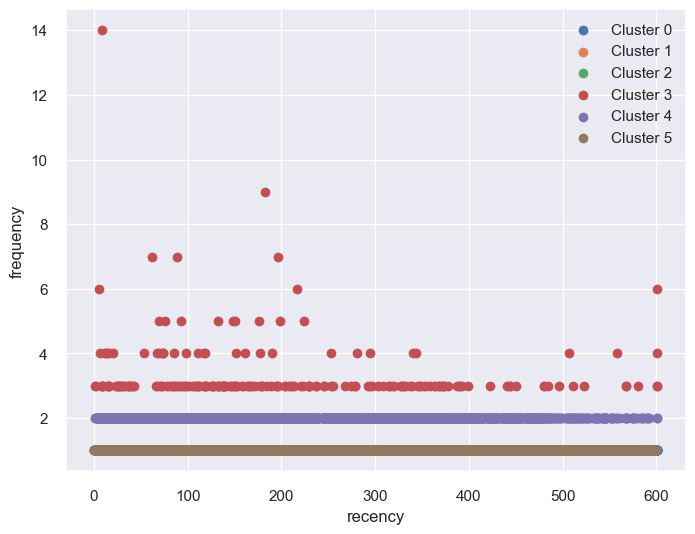

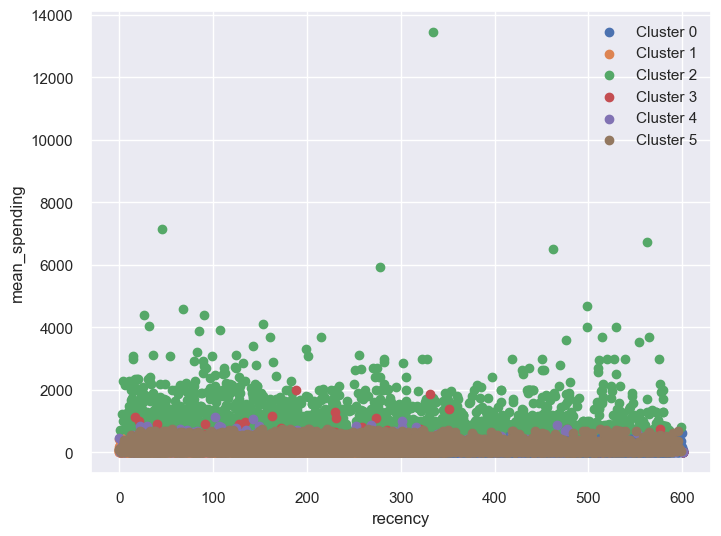

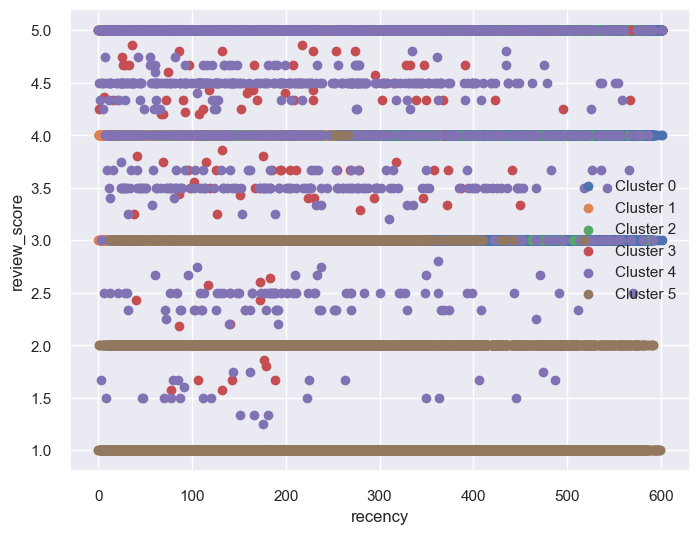

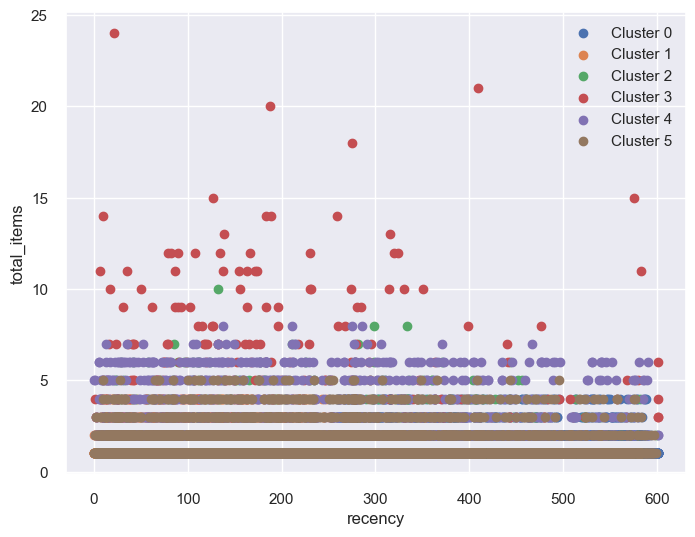

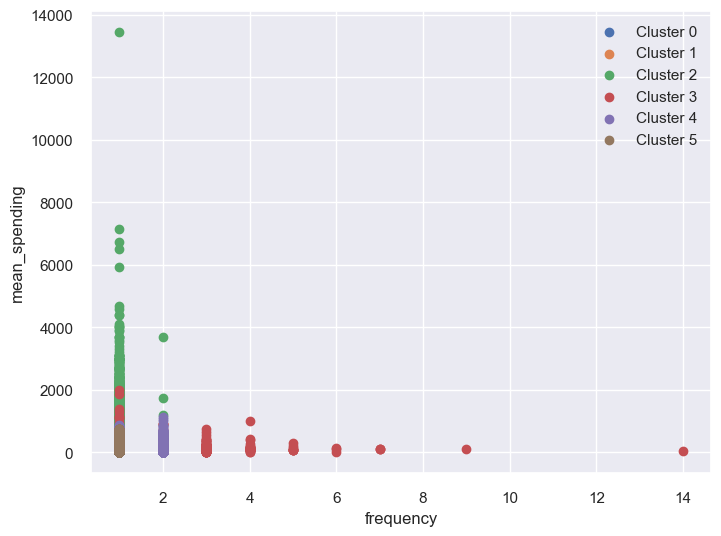

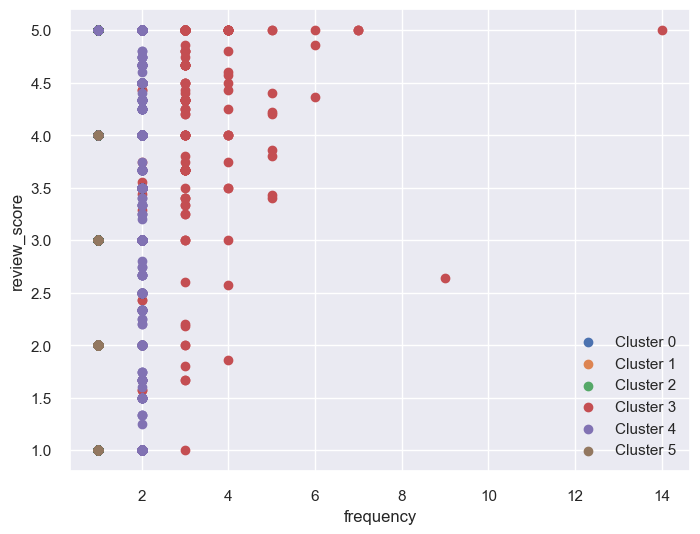

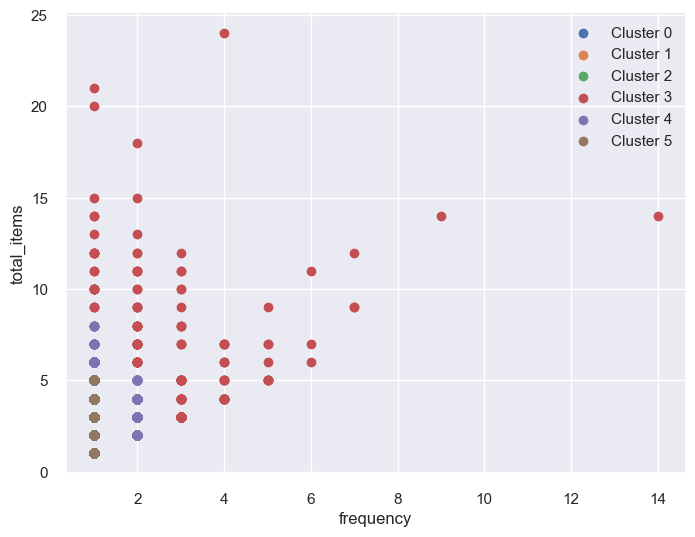

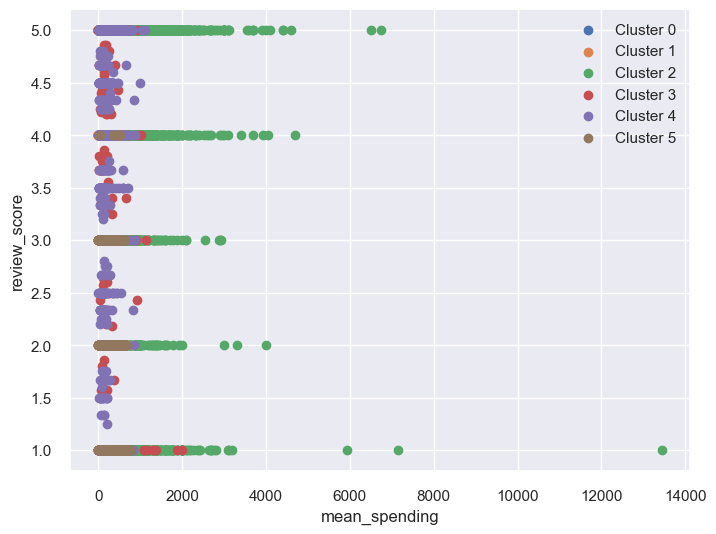

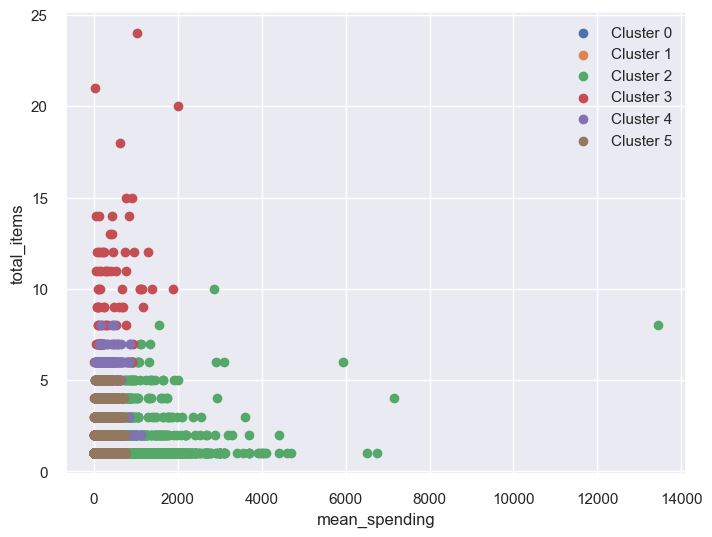

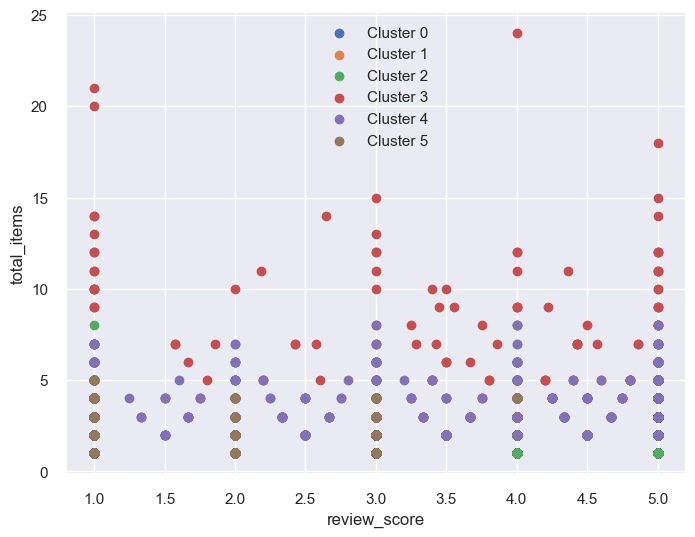

In [98]:
for (i, j) in itertools.combinations(range(X_rfmst.shape[1]), 2):
    plt.figure()
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        plt.scatter(X_rfmst.iloc[mask, i], X_rfmst.iloc[mask, j], label='Cluster {}'.format(cluster))
    #plt.xticks(rotation=30)
    plt.xlabel(X_rfmst.columns[i])
    plt.ylabel(X_rfmst.columns[j])
    plt.legend();

#### Box plots

In [99]:
df_rfmst['cluster'] = clusters

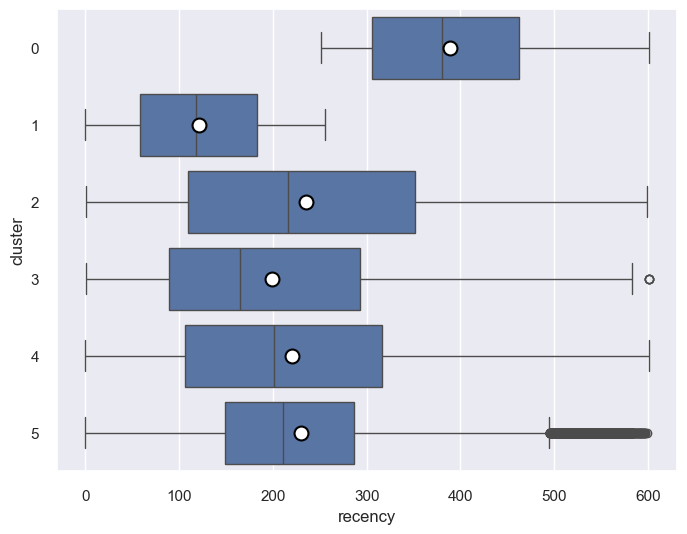

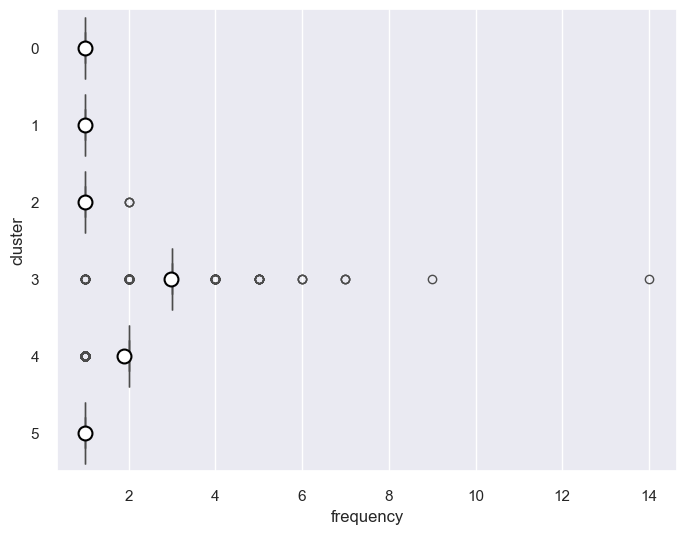

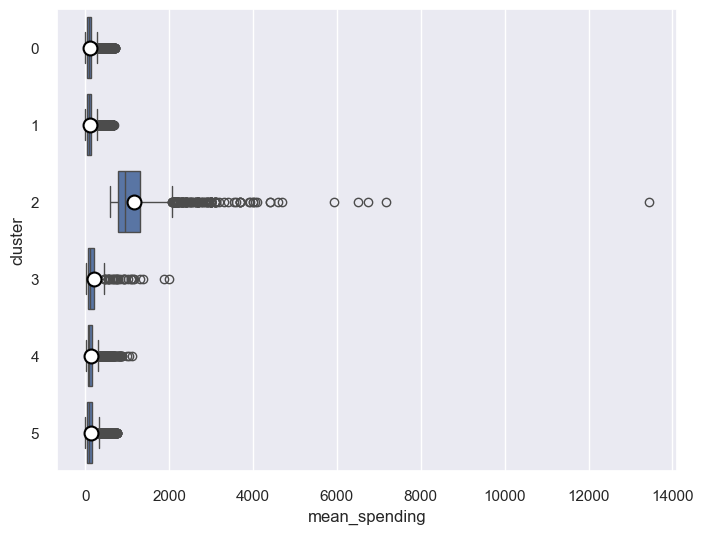

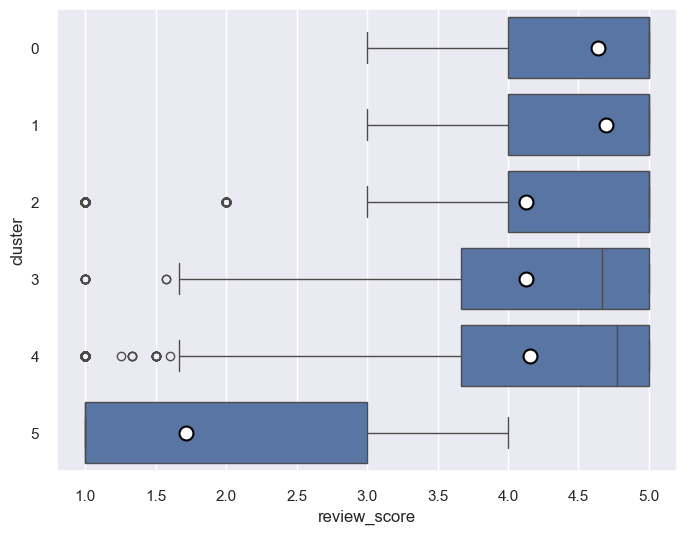

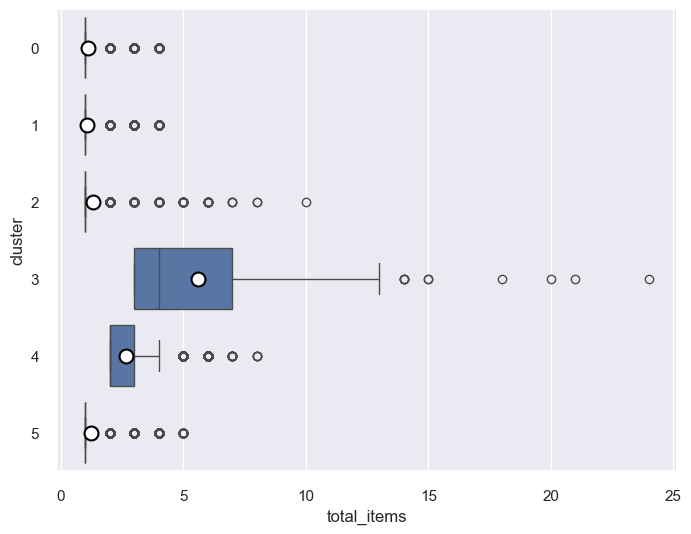

In [100]:
for col in df_rfmst.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=df_rfmst, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

#### Distribution plots

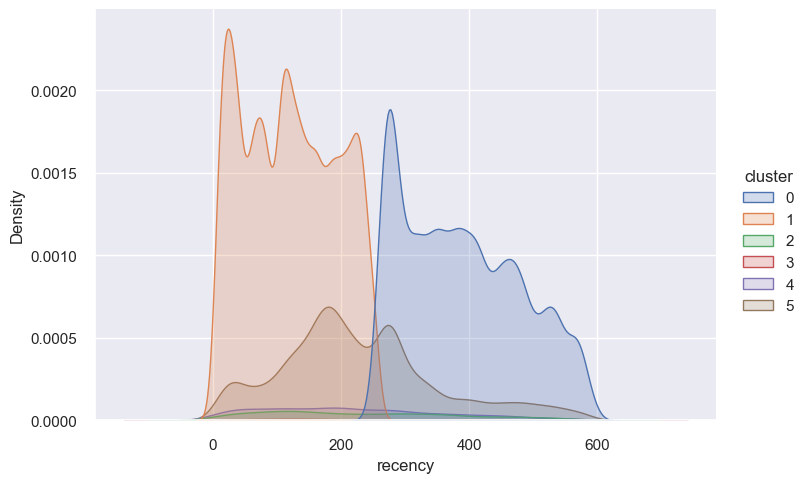

In [101]:
sns.displot(x='recency', data=df_rfmst, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5);

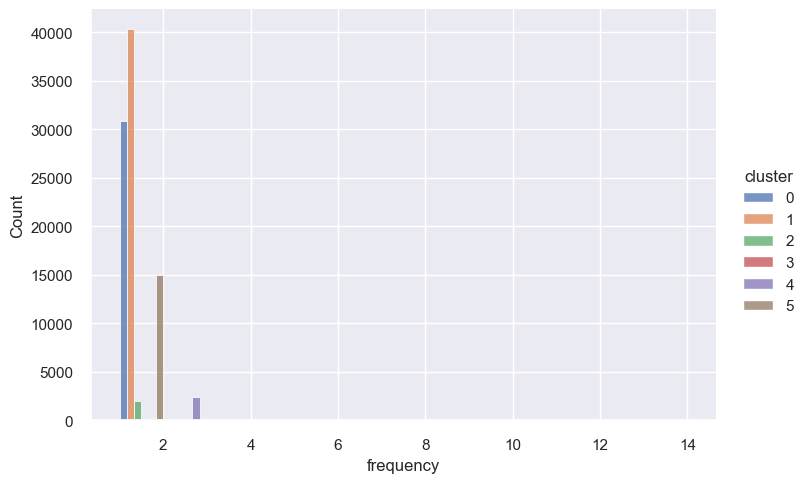

In [102]:
sns.displot(x='frequency', data=df_rfmst, hue='cluster', kind='hist', palette='deep', aspect=1.5, 
            binwidth=1, multiple='dodge');

In [103]:
pd.crosstab(df_rfmst['frequency'], df_rfmst['cluster'])

cluster,0,1,2,3,4,5
frequency,,,,,,
1,30886,40361,1974,21,278,15007
2,0,0,3,48,2428,0
3,0,0,0,168,0,0
4,0,0,0,29,0,0
5,0,0,0,9,0,0
6,0,0,0,3,0,0
7,0,0,0,3,0,0
9,0,0,0,1,0,0
14,0,0,0,1,0,0


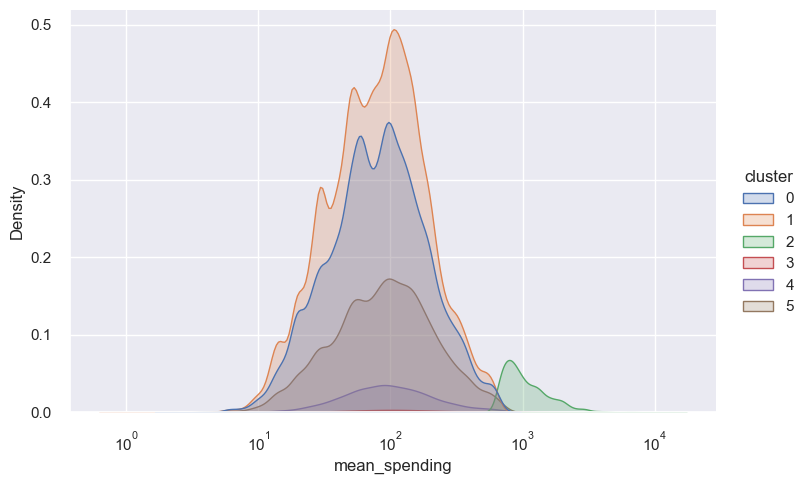

In [104]:
sns.displot(x='mean_spending', data=df_rfmst, hue='cluster', kind='kde', fill=True, 
            palette='deep', aspect=1.5, log_scale=True);

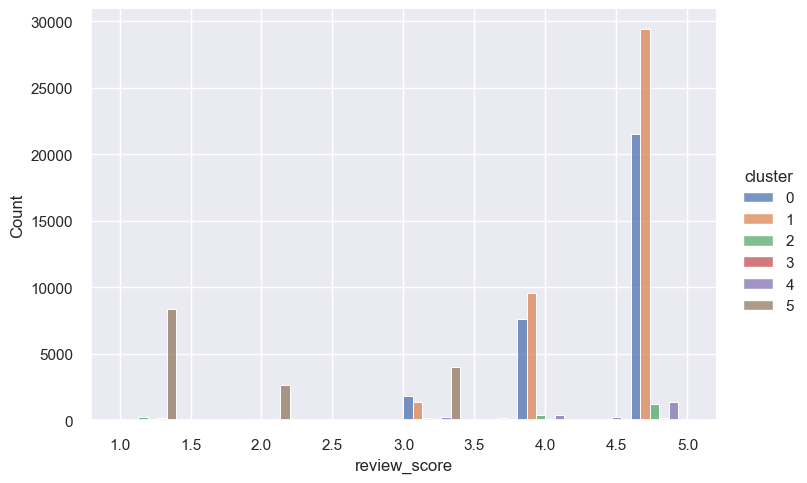

In [105]:
sns.displot(x='review_score', data=df_rfmst, hue='cluster', aspect=1.5, palette='deep', multiple='dodge',
           bins=10);

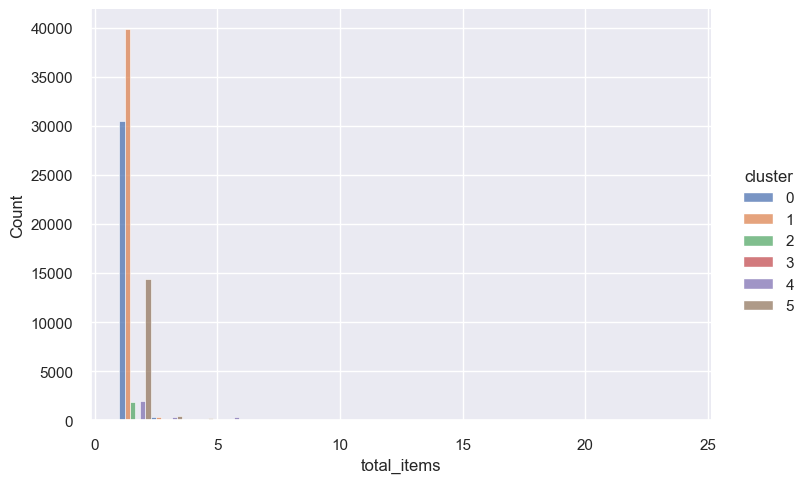

In [106]:
sns.displot(x='total_items', data=df_rfmst, hue='cluster', aspect=1.5, palette='deep', multiple='dodge');

In [107]:
pd.crosstab(df_rfmst['total_items'], df_rfmst['cluster'])

cluster,0,1,2,3,4,5
total_items,,,,,,
1,28499,37558,1673,0,0,12234
2,1989,2353,148,0,1908,2144
3,299,344,60,109,353,424
4,99,106,48,42,131,173
5,0,0,26,31,150,32
6,0,0,16,19,143,0
7,0,0,3,23,17,0
8,0,0,2,9,4,0
9,0,0,0,11,0,0


Frequent customers and those who have purchased many items are mixed into two different clusters.

# RFMSA Segmentation

In [108]:
df_rfmsa = pd.read_csv('./data/df_rfmsa.csv', index_col=0)
df_rfmsa.head()

,recency,frequency,mean_spending,review_score,items_per_order
customer_unique_id,,,,,
4b3207464f5f7a48a7f63fa0b1251d86,601,1,9.9,5.0,1
527cd2850ef91088969ffbef0103dec3,601,1,11.9,5.0,1
29a63a400c3ca9982907ce8de1f19527,601,1,10.9,5.0,1
b6b2c3c8fd76769b478618a3c2505009,601,1,10.9,5.0,1
f7be9bec658c62ab6240b44cd26c0b84,601,2,10.4,5.0,1


## KMeans

In [109]:
from sklearn.cluster import KMeans

In [110]:
X_rfmsa = df_rfmsa.copy()

scaler = StandardScaler()
X_rfmsa_scaled = scaler.fit_transform(X_rfmsa)
X_rfmsa_scaled = pd.DataFrame(X_rfmsa_scaled, columns=X_rfmsa.columns, index=X_rfmsa.index)

### Analysis with Yellowbrick

In [111]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_theme()
plt.rcParams['figure.figsize'] = (8, 6)

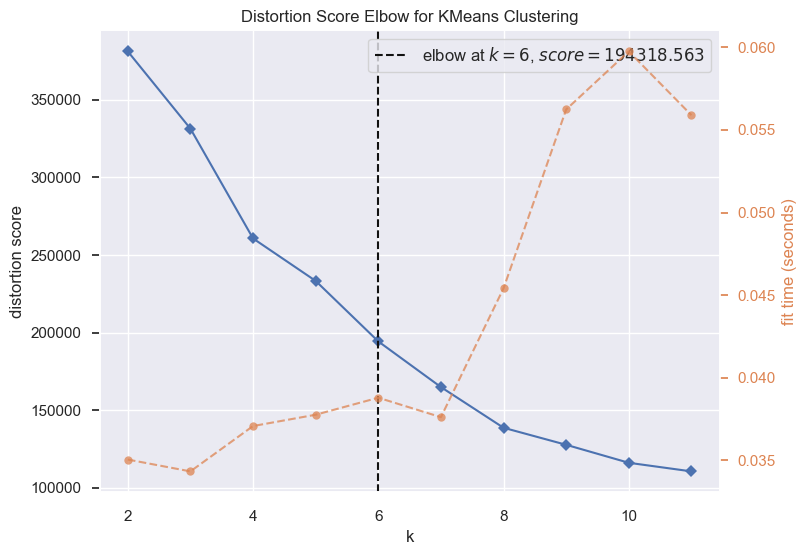

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [112]:
# Instantiate the clustering model and visualizer
kmeans = KMeans()
plt.rcParams['figure.figsize'] = (8,6)
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(X_rfmsa_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

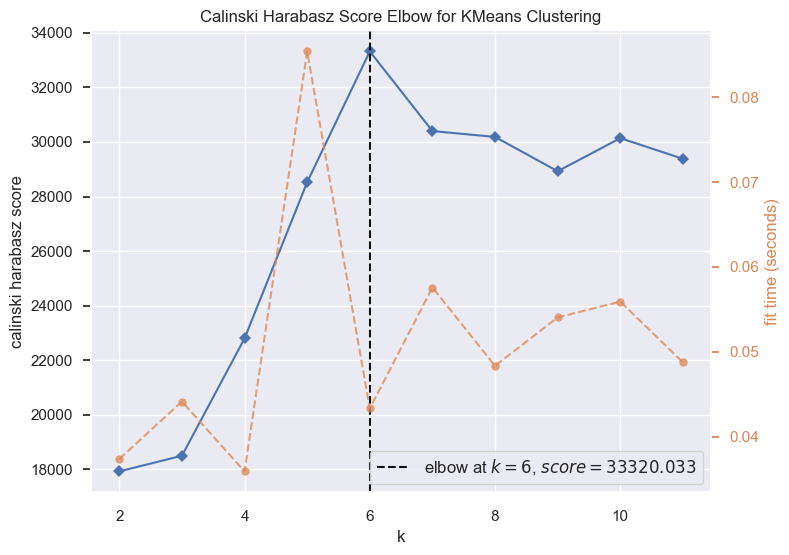

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [113]:
# Instantiate the clustering model and visualizer 
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz')

visualizer.fit(X_rfmsa_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

In [114]:
X_rfmsa_sample = X_rfmsa.sample(10000, random_state=1)
X_rfmsa_scaled_sample = scaler.transform(X_rfmsa_sample)
X_rfmsa_scaled_sample = pd.DataFrame(X_rfmsa_scaled_sample, 
                                    index=X_rfmsa_sample.index, columns=X_rfmsa_sample.columns)

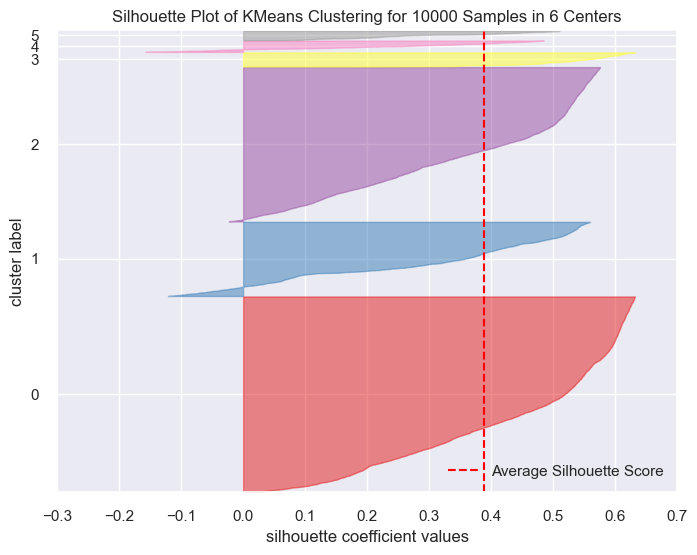

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [115]:
n_clust = 6
# Instantiate the clustering model and visualizer
kmeans = KMeans(n_clust, random_state=0)
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_rfmsa_scaled_sample)    # Fit the data to the visualizer
visualizer.poof()    # Draw the data

In [116]:
from sklearn.metrics import silhouette_score
labels = kmeans.labels_
silhouette_score(X_rfmsa_scaled_sample, labels, metric='euclidean')

np.float64(0.3891913882975755)

### Clustering

In [117]:
n_clust = 6
kmeans = KMeans(n_clusters=n_clust, random_state=12)
kmeans.fit(X_rfmsa_scaled)
clusters = kmeans.labels_
np.unique(clusters)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [118]:
# Number of customers per cluster
pd.Series(clusters).value_counts()

2    39999
0    30697
1    14857
3     2995
5     2458
4      214
Name: count, dtype: int64

### Visualization

#### Box plots

In [119]:
df_rfmsa['cluster'] = clusters

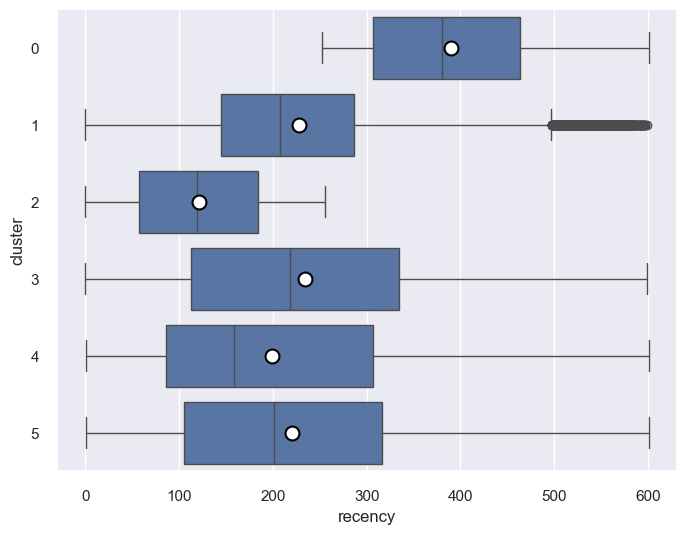

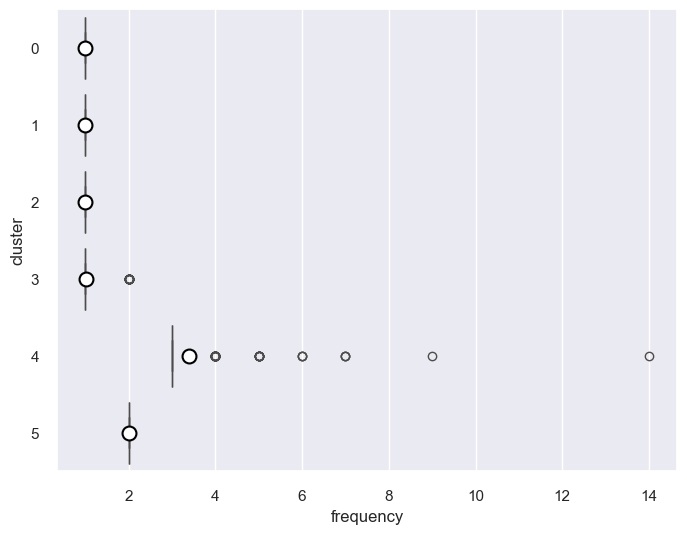

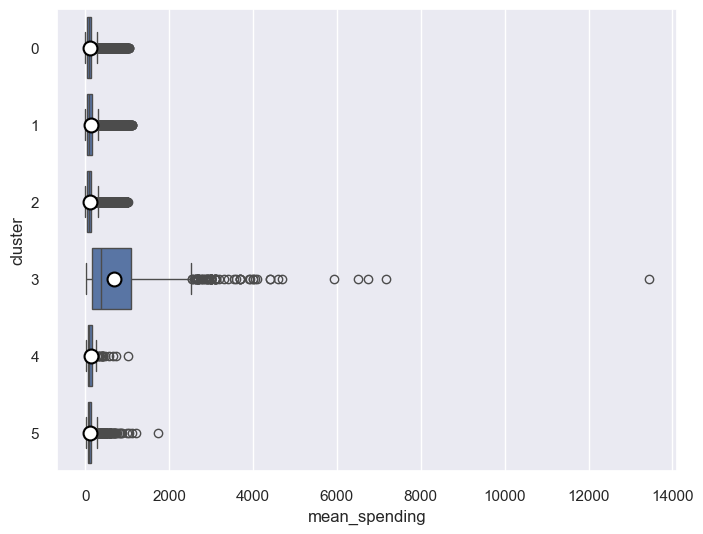

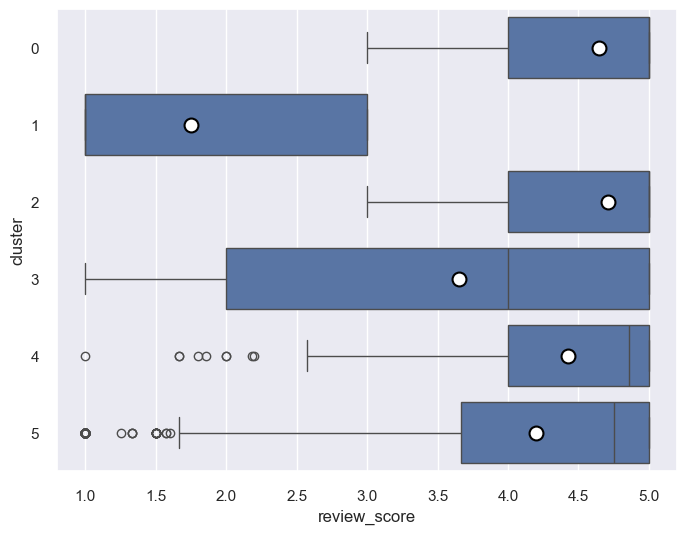

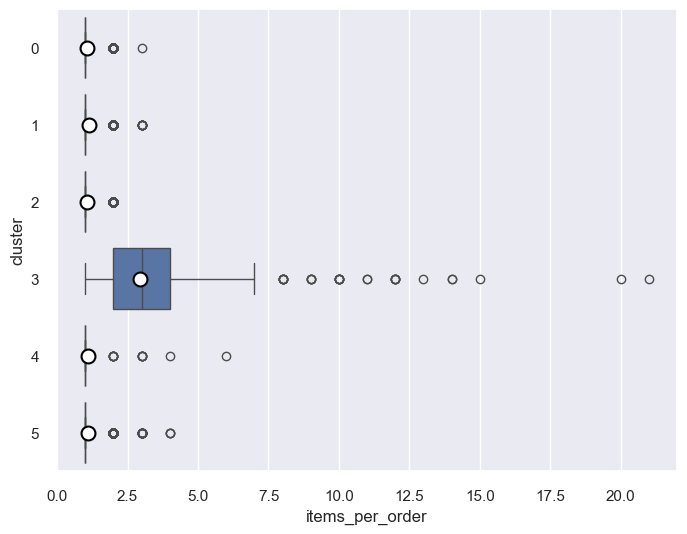

In [120]:
for col in df_rfmsa.columns[:-1]:
    plt.figure()
    sns.boxplot(x=col, y='cluster', data=df_rfmsa, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

#### Distribution plots

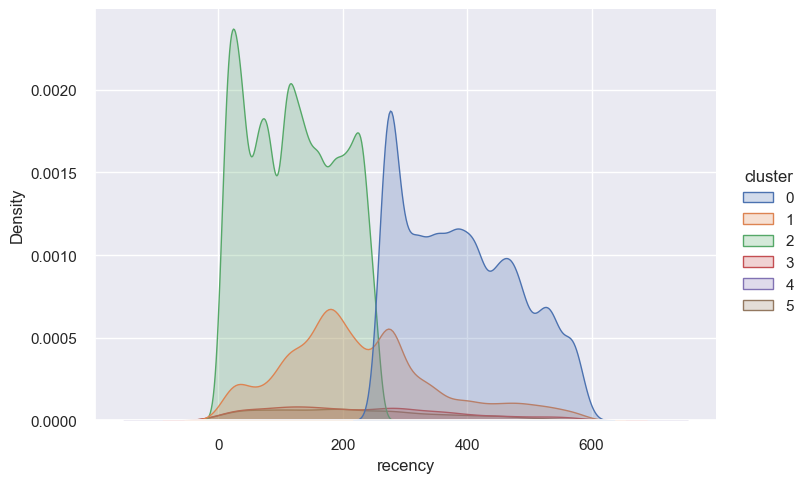

In [121]:
sns.displot(x='recency', data=df_rfmsa, hue='cluster', kind='kde', fill=True, palette='deep', aspect=1.5);

In [122]:
pd.crosstab(df_rfmsa['frequency'], df_rfmsa['cluster'])

cluster,0,1,2,3,4,5
frequency,,,,,,
1,30697,14857,39999,2974,0,0
2,0,0,0,21,0,2458
3,0,0,0,0,168,0
4,0,0,0,0,29,0
5,0,0,0,0,9,0
6,0,0,0,0,3,0
7,0,0,0,0,3,0
9,0,0,0,0,1,0
14,0,0,0,0,1,0


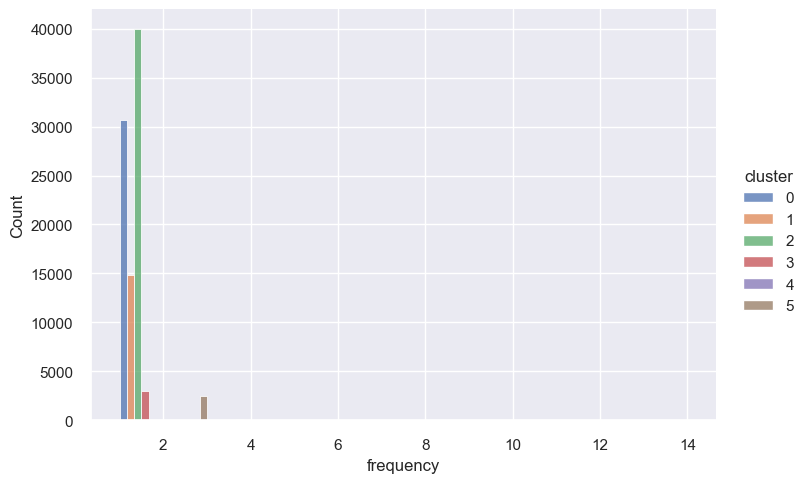

In [123]:
sns.displot(x='frequency', data=df_rfmsa, hue='cluster', kind='hist', palette='deep', aspect=1.5, 
            binwidth=1, multiple='dodge');

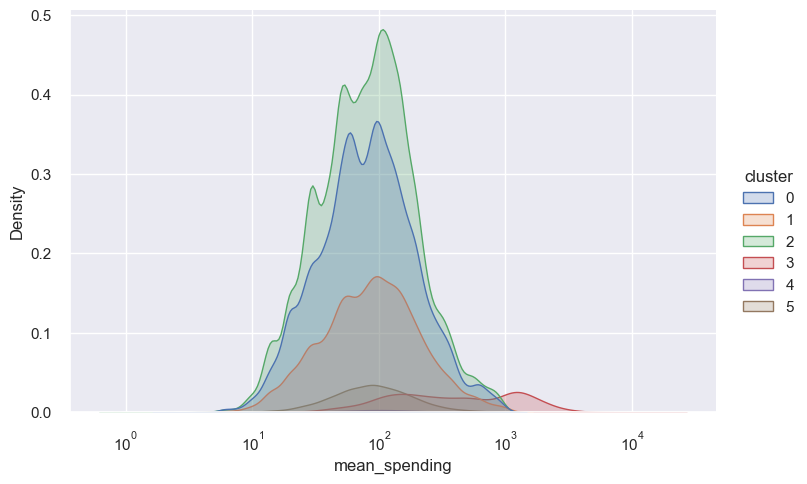

In [124]:
sns.displot(x='mean_spending', data=df_rfmsa, hue='cluster', kind='kde', fill=True, palette='deep', 
            aspect=1.5, log_scale=True);

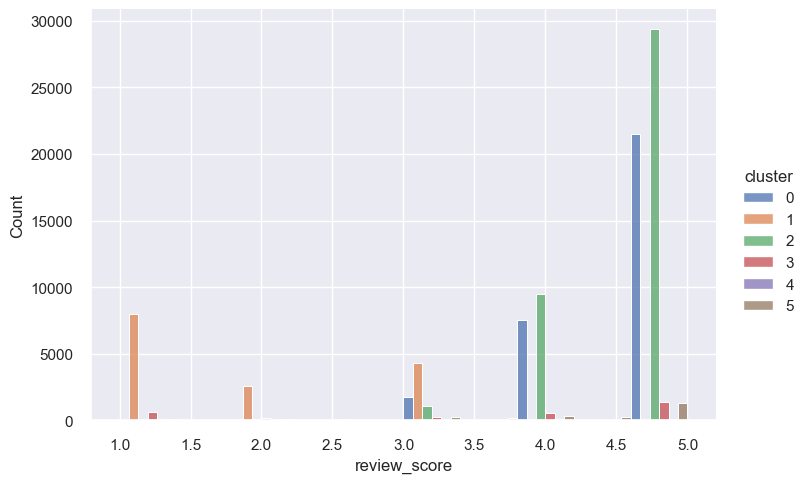

In [125]:
sns.displot(x='review_score', data=df_rfmsa, hue='cluster', aspect=1.5, palette='deep', multiple='dodge',
           bins=10);

In [126]:
pd.crosstab(df_rfmsa['items_per_order'], df_rfmsa['cluster'])

cluster,0,1,2,3,4,5
items_per_order,,,,,,
1,28765,12762,37696,742,201,2263
2,1931,2086,2303,311,6,167
3,1,9,0,1119,5,25
4,0,0,0,433,1,3
5,0,0,0,178,0,0
6,0,0,0,162,1,0
7,0,0,0,21,0,0
8,0,0,0,6,0,0
9,0,0,0,4,0,0


This time, the segmentation seems better than when using the total number of items. We can see that:
- Cluster 0 represents recent customers
- Cluster 1 represents long-standing customers
- Cluster 2 represents customers who have ordered a large number of items on average
- Cluster 3 represents unsatisfied customers
- Cluster 4 represents high-spending customers
- Cluster 5 represents frequent customers